# MOSCOW REAL ESTATE PRICES
**_Doing to houses & apartments what we did to cars_**
### Data Science 410 BB
#### University of Washington Professional & Continuing Education
#### FINAL PROJECT
#### Leo Salemann, 3/10/18

# INTRODUCTION

Our dataset comes from a [Kaggle competition to predict real Moscow esate prices](https://www.kaggle.com/c/sberbank-russian-housing-market). I first encountered this data in a [team project](https://www.slideshare.net/LeoSalemann/predicting-moscow-real-estate-prices-with-azure-machine-learning) for [UW PCE Big Data Technologies - Introduciton to Data Engineering](https://www.pce.uw.edu/courses/introduction-to-data-engineering). We used [Microsoft Azure Machine Learning Studio](https://gallery.cortanaintelligence.com/Experiment/D-Hawks-Big-Data-Project-Leo-RevS) to look at multiple approaches to feature engineering, and try multiple machine learning models simultaneosly. For this project, we'll extract realestate data from Azure ML Studio, after cleaning but before any Azure ML modeling.  We'll then do our own feature analysis in Jupyter Notebook with R.

The [original kaggle datasets](https://www.kaggle.com/c/sberbank-russian-housing-market/data) consisted of two tables: Real Estate Transactions and Macro Economics. The Real Estate Transactions table includes price, timestamp, year built, property descriptors such as  square footage, number of floors, condition, etc. and neighborhood descriptors such as nearby transportation, industry, population demographics. 

Azure ML Studio Summary
1. Start with the original 30,471 rows and 292 columns
1. Select 64 columns to work with.
1. Set a bunch of numeric data to floating point, integer, category
1. Clean missing data
1. Apply SQL Transofmation (see below)
1. Normalize non-categorical rows


Cleaning missing data

|Field                         |Set To   |Rows Affected|
|------------------------------|---------|-------------|
|build_year                    |1979     |13,605       |
|life_sq (living space, m$^2$) |30       | 6,383       |
|floor (level above ground)    |7        |   167       |
|num_room                      |2        | 9,572       |
|kitch_sq (kitchen space m$^2$)|6        | 9,572       |
|material                      |mode\*   | 9,672       |
|state                         |MICE\*\* |0            |
|full_sq (total m$^2$)         |mode\*   |0            |
|max_floor (highest, 0=ground) |0        | 9,571       |
|metro_min_walk                |median   |    25       |
|railroad_station_walk_km      |median   |    25       |
|railroad_station_walk_min     |median   |    25       |
|metro_km_walk                 |median   |    25       |




\* replace nulls with the mode of the non-null data

\*\* [Multivariate Imputation using Chaned Equations](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/clean-missing-data)

## SQL Filtering

# DATA EXPLORATION

## Load the data, have a quick look

In [1]:
# real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql_normed.csv")
real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql.csv")
dim(real_estate)
head(real_estate)
str(real_estate)

[1] 15693    64

timestamp             full_sq life_sq floor max_floor material build_year
1 4/27/2013 12:00:00 AM 73      36      17    17        1        1979      
2 5/25/2013 12:00:00 AM 53      30      10    16        1        1980      
3 5/27/2013 12:00:00 AM 41      37      13    17        1        1979      
4 5/27/2013 12:00:00 AM 77      41       2    17        6        2014      
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
  num_room kitch_sq state ⋯ prom_part_2000 office_count_2000 office_sqm_2000
1 2        11       3     ⋯  8.44           0                     0         
2 2         8       3     ⋯ 17.64          10                179554         
3 1         1       1     ⋯  1.45           0                     0         
4 3        12       1     ⋯  1.64           0                     0         
5 2         6       3     ⋯  0.74           0                     0         
6 1         8       3     ⋯ 21.51           4                 31280         
  prom_part_3000 office_count_3000 office_sqm_3000 prom_part_5000
1  8.28           0                     0           6.22         
2 16.69          14                529054          18.47         
3  2.01           0                     0           4.45         
4  1.98           0                     0           4.75         
5  1.99           1                 15000           8.05         
6 18.78          15                136990          11.12         
  office_count_5000 office_sqm_5000 price_doc
1  2                 138650         10100000 
2 25                 766701          9000000 
3  0                      0          4457400 
4  0                      0          7011550 
5  3                  81947          7100000 
6 83                3903973          6450000

'data.frame':	15693 obs. of  64 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 335 382 387 387 387 390 390 395 416 464 ...
 $ full_sq                          : int  73 53 41 77 45 38 63 74 51 77 ...
 $ life_sq                          : int  36 30 37 41 27 20 30 46 30 50 ...
 $ floor                            : int  17 10 13 2 6 15 17 12 7 3 ...
 $ max_floor                        : int  17 16 17 17 9 16 17 24 17 5 ...
 $ material                         : int  1 1 1 6 1 1 4 1 1 2 ...
 $ build_year                       : int  1979 1980 1979 2014 1970 1982 2013 2004 2003 1957 ...
 $ num_room                         : int  2 2 1 3 2 1 2 3 2 3 ...
 $ kitch_sq                         : int  11 8 1 12 6 8 1 9 9 8 ...
 $ state                            : int  3 3 1 1 3 3 1 3 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 2 1 1 2 1 1 1 ...
 $ sub_area                         : Factor 

## Data Cleanups
 - **Drop NA Values**
 - **Parse the Date**
 - **Create a price per square meter**

In [2]:
real_estate = na.omit(real_estate)
dim(real_estate)
real_estate$date = as.Date(real_estate$timestamp,format='%m/%d/%Y')
real_estate$year_sold  = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%Y'))
real_estate$month_sold = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%m'))
real_estate$day_sold   = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%d'))
real_estate$price_sqm = real_estate$price_doc/real_estate$full_sq
head(real_estate, 3)
str(real_estate)

[1] 9233   64

timestamp             full_sq life_sq floor max_floor material build_year
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7 5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
  num_room kitch_sq state ⋯ office_sqm_3000 prom_part_5000 office_count_5000
5 2        6        3     ⋯  15000           8.05           3               
6 1        8        3     ⋯ 136990          11.12          83               
7 2        1        1     ⋯      0           6.54           1               
  office_sqm_5000 price_doc date       year_sold month_sold day_sold price_sqm
5   81947         7100000   2013-05-27 2013      5          27       157777.78
6 3903973         6450000   2013-05-28 2013      5          28       169736.84
7   26950         5903808   2013-05-28 2013      5          28        93711.24

'data.frame':	9233 obs. of  69 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

## Density Plot for Price

Loading required package: ggplot2


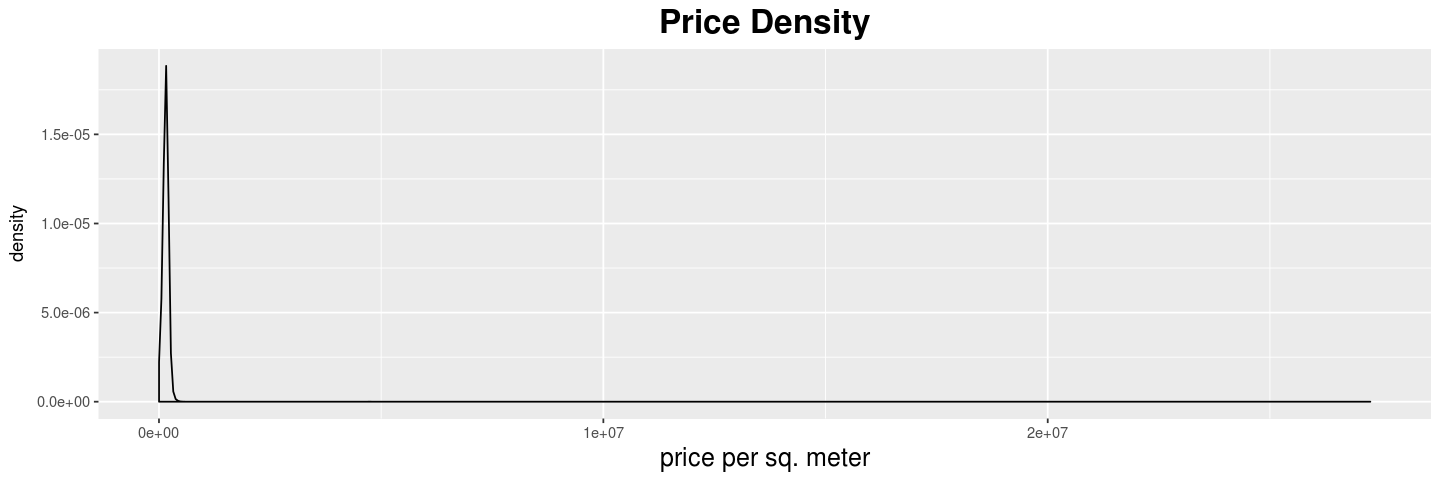

In [3]:
require(ggplot2)
options(repr.plot.width=12, repr.plot.height=4)
ggplot(real_estate, aes(price_sqm)) + 
      geom_density() + 
      xlab("price per sq. meter") + 
      ggtitle("Price Density") + 
      theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"),
           axis.title.x = element_text(size=15))

## Take the log, Plot again

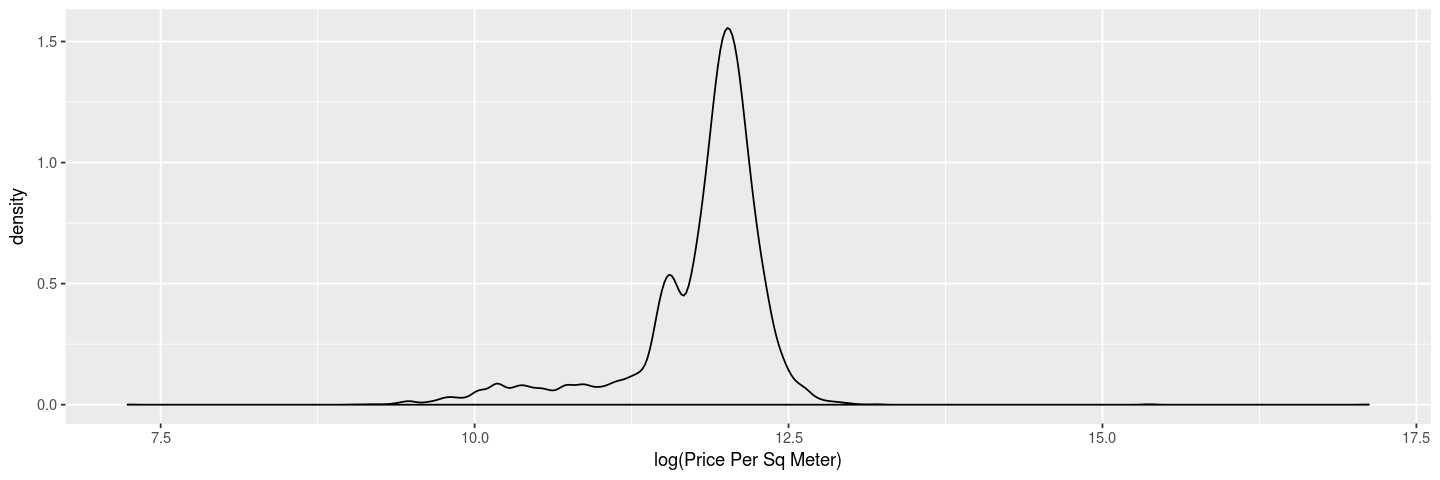

In [4]:
options(repr.plot.width=12, repr.plot.height=4)
real_estate$log.price_sqm = log(real_estate$price_sqm)
# head(real_estate)
ggplot(real_estate, aes(log.price_sqm)) + geom_density() + 
xlab('log(Price Per Sq Meter)')

## Trim the tails, Plot again

Warning message:
“Removed 785 rows containing non-finite values (stat_density).”

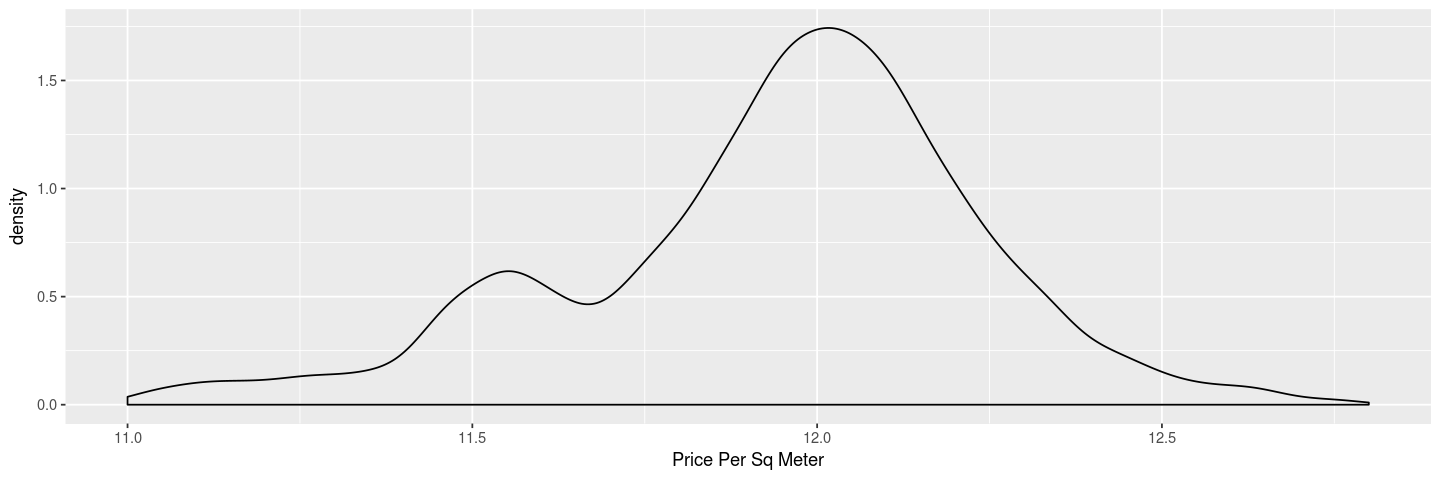

In [71]:
x_min = 11 # was 9.5
x_max = 12.8

ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter') + 
xlim(c(x_min, x_max)) 

## Use what we learned to trim the dataframe

In [72]:
real_estate.trimmed = real_estate[real_estate$log.price_sqm <= x_max,]
real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$log.price_sqm >= x_min,]
dim(real_estate)
dim(real_estate.trimmed)
real_estate = real_estate.trimmed

[1] 9181   71

[1] 8396   71

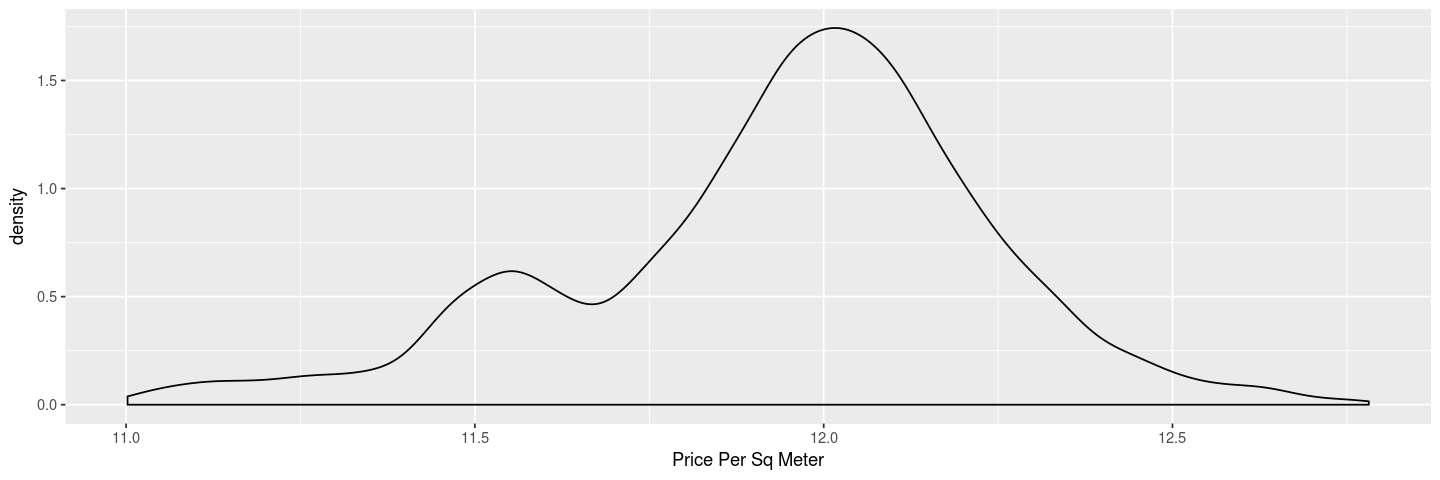

In [73]:
ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter')

## A Scattering of Scatterplots: The search for meaning

We've got 70 features and 9,181 oveservations. Time to walk thru the dataset looking for features that have some kind of relationship with price per square foot. As we go along, we'll keep track of features which have non-zero trendlines, or that show promise as a categorical feature for splitting data.  Basically, we're looking for regression lines (solid green) with non-zero slopes and narrow confidence intervals (dashed red).  For categoricals, we're looking for "spiky" density plots.

In [84]:
panel.hist = function(x, ...){
  usr = par('usr')
  on.exit(par(usr))
  par(usr = c(usr[1:2], 0, 1.5))
  h = hist(x, plot=FALSE)
  breaks = h$breaks
  nB = length(breaks)
  y=h$counts
  y=y/max(y)
  rect(breaks[-nB], 0, breaks[-1], y, col='white')
}

panel.cor = function(x, y, digits=2, prefix="", cex.cor, ...){
  usr = par("usr")
  on.exit(par(usr))
  par(usr = c(0,1,0,1))
  r = abs(cor(x,y,use='complete.obs'))
  txt=format(c(r,0.123456789),digits=digits)[1]
  txt=paste(prefix,txt,sep='')
  if(missing(cex.cor)) cex.cor = 0.8/strwidth(txt)
  text(0.5, 0.5, txt, cex = cex.cor*(1+r)/2)
}



In [85]:
pairs(real_estate[,0:10], 
      diag.panel = panel.hist,
      upper.panel = real_estate)

ERROR: Error in get(as.character(FUN), mode = "function", envir = envir): object 'real_estate' of mode 'function' was not found


In [74]:
panel.cor = function(x, y, digits=2, prefix="", cex.cor, ...){
  usr = par("usr")
  on.exit(par(usr))
  par(usr = c(0,1,0,1))
  r = abs(cor(x,y,use='complete.obs'))
  txt=format(c(r,0.123456789),digits=digits)[1]
  txt=paste(prefix,txt,sep='')
  if(missing(cex.cor)) cex.cor = 0.8/strwidth(txt)
  text(0.5, 0.5, txt, cex = cex.cor*(1+r)/2)
}

ERROR: Error in is.data.frame(y): argument "y" is missing, with no default


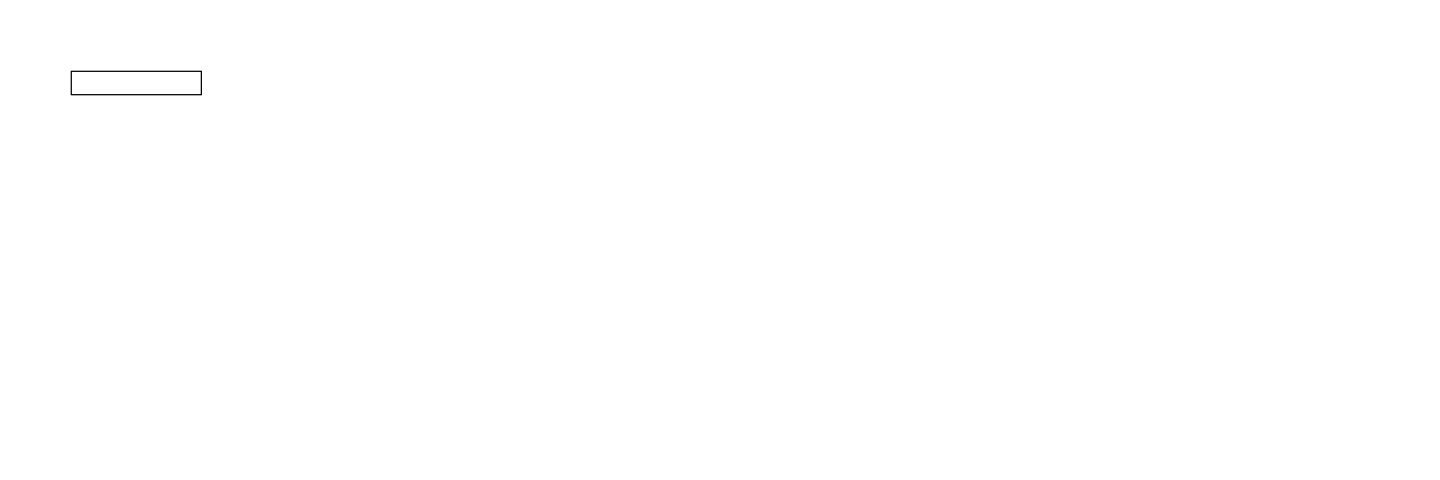

In [83]:
pairs(real_estate[,1:9], 
      diag.panel = panel.cor,
      upper.panel = panel.cor)

In [77]:
head(real_estate, 3)
dim(real_estate)

timestamp             full_sq life_sq floor max_floor material build_year
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7 5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
  num_room kitch_sq state ⋯ office_count_5000 office_sqm_5000 price_doc
5 2        6        3     ⋯  3                  81947         7100000  
6 1        8        3     ⋯ 83                3903973         6450000  
7 2        1        1     ⋯  1                  26950         5903808  
  date       year_sold month_sold day_sold price_sqm log.price_sqm century
5 2013-05-27 2013      5          27       157777.78 11.96894      20     
6 2013-05-28 2013      5          28       169736.84 12.04200      20     
7 2013-05-28 2013      5          28        93711.24 11.44797      21

[1] 8396   71

In [81]:
real_estate[,c(1:3, 70)]

timestamp             full_sq life_sq log.price_sqm
5     5/27/2013 12:00:00 AM  45     27      11.96894     
6     5/28/2013 12:00:00 AM  38     20      12.04200     
7     5/28/2013 12:00:00 AM  63     30      11.44797     
8     5/30/2013 12:00:00 AM  74     46      12.00465     
9     6/1/2013 12:00:00 AM   51     30      11.92491     
10    6/3/2013 12:00:00 AM   77     50      11.93129     
16    6/7/2013 12:00:00 AM   52     33      12.28018     
17    6/7/2013 12:00:00 AM   56     29      12.13196     
18    6/7/2013 12:00:00 AM   31     21      12.20607     
19    6/10/2013 12:00:00 AM  43     27      11.83770     
20    6/10/2013 12:00:00 AM  46     29      11.76182     
24    6/11/2013 12:00:00 AM  38     24      11.68200     
25    6/11/2013 12:00:00 AM  54     32      11.34595     
27    6/14/2013 12:00:00 AM  40     24      12.11451     
30    6/15/2013 12:00:00 AM  56     38      12.14153     
32    6/17/2013 12:00:00 AM  38     23      12.08003     
35    6/19/2013 12:00:00 AM  46     45      11.74473     
36    6/19/2013 12:00:00 AM  43     27      12.69337     
37    6/19/2013 12:00:00 AM 114     69      12.42922     
39    6/19/2013 12:00:00 AM  44     27      11.96284     
41    6/20/2013 12:00:00 AM  39     20      11.73093     
43    6/20/2013 12:00:00 AM  41     17      11.20055     
45    6/22/2013 12:00:00 AM  54     32      12.15867     
47    6/24/2013 12:00:00 AM  42     28      12.05884     
48    6/24/2013 12:00:00 AM  44     28      12.11076     
49    6/24/2013 12:00:00 AM  36     19      12.04028     
51    6/24/2013 12:00:00 AM  45     28      11.92209     
52    6/25/2013 12:00:00 AM  41     30      11.21277     
54    6/25/2013 12:00:00 AM  61     32      12.14698     
55    6/26/2013 12:00:00 AM  44     30      11.76298     
⋮     ⋮                     ⋮       ⋮       ⋮            
15640 6/24/2015 12:00:00 AM 109     60      12.77222     
15641 6/24/2015 12:00:00 AM  45     30      11.95476     
15645 6/24/2015 12:00:00 AM  79     30      11.43486     
15646 6/24/2015 12:00:00 AM  63     30      11.55929     
15648 6/24/2015 12:00:00 AM  42     17      12.11906     
15651 6/25/2015 12:00:00 AM  42     28      12.11906     
15653 6/25/2015 12:00:00 AM  39     39      11.65931     
15654 6/25/2015 12:00:00 AM  48     30      11.17154     
15655 6/25/2015 12:00:00 AM  54     28      11.90597     
15660 6/25/2015 12:00:00 AM  37     18      11.95548     
15662 6/25/2015 12:00:00 AM  37     20      12.04855     
15664 6/26/2015 12:00:00 AM  80     57      11.97486     
15667 6/26/2015 12:00:00 AM  76     44      12.32969     
15668 6/26/2015 12:00:00 AM  39     20      12.05406     
15669 6/26/2015 12:00:00 AM  56     40      11.99159     
15670 6/26/2015 12:00:00 AM  88     58      12.33391     
15671 6/27/2015 12:00:00 AM 113      1      12.30857     
15674 6/27/2015 12:00:00 AM  47     47      12.28179     
15675 6/27/2015 12:00:00 AM  64     30      11.50875     
15677 6/27/2015 12:00:00 AM  47     47      12.18757     
15678 6/29/2015 12:00:00 AM  38     19      12.09485     
15683 6/29/2015 12:00:00 AM  58     43      11.80919     
15684 6/29/2015 12:00:00 AM  51     30      11.63790     
15685 6/30/2015 12:00:00 AM  36     19      11.84143     
15686 6/30/2015 12:00:00 AM  47     30      12.32093     
15687 6/30/2015 12:00:00 AM  56     29      12.27507     
15688 6/30/2015 12:00:00 AM  56     51      12.11861     
15689 6/30/2015 12:00:00 AM  52     30      11.77389     
15692 6/30/2015 12:00:00 AM  64     32      12.25932     
15693 6/30/2015 12:00:00 AM  43     28      11.77708

In [ ]:
real_estate[,c(1:3, 70)]

Warning message in warn_if_args_exist(list(...)):
“Extra arguments: 'colour' are being ignored.  If these are meant to be aesthetics, submit them using the 'mapping' variable within ggpairs with ggplot2::aes or ggplot2::aes_string.”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


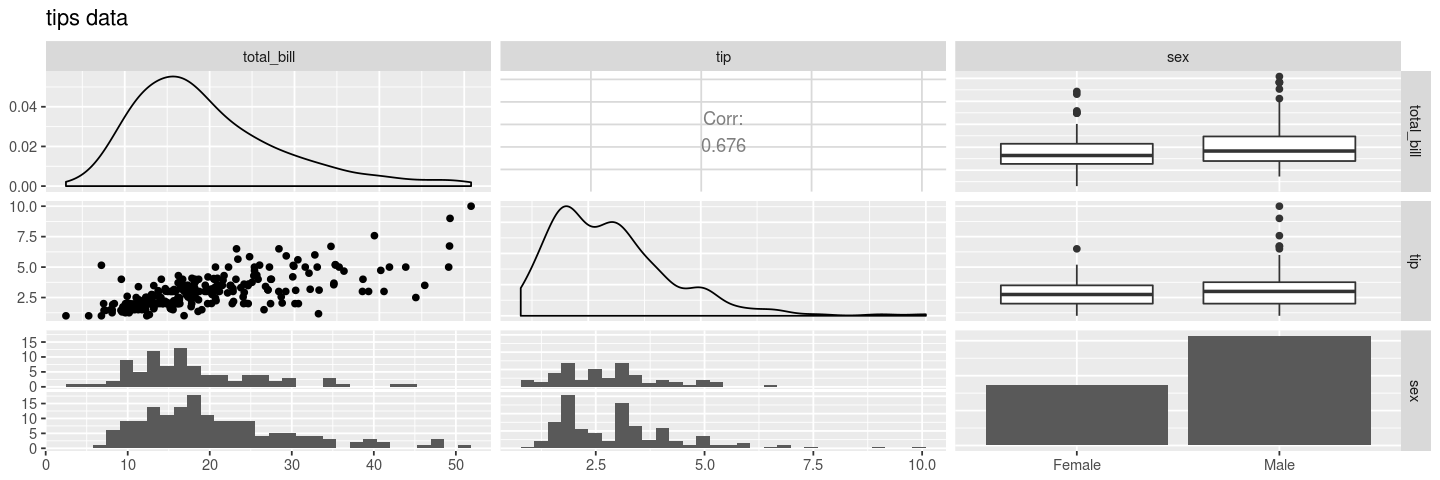

In [91]:
require(GGally)
data(tips, package="reshape")
 
ggpairs(data=tips, # data.frame with variables
        columns=1:3, # columns to plot, default to all.
        title="tips data", # title of the plot
        colour = "sex") # aesthetics, ggplot2 style

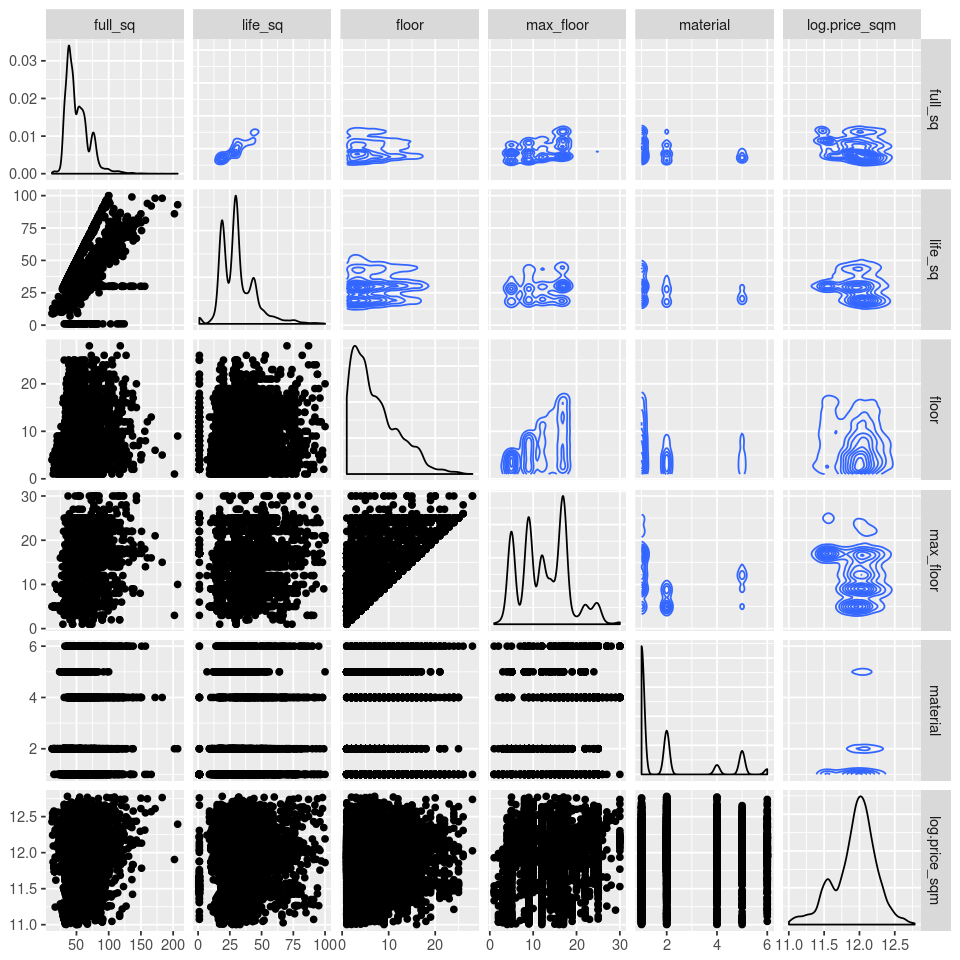

In [106]:
options(repr.plot.width=8, repr.plot.height=8)
ggpairs(data=real_estate,
             columns=c(2:6,70),
             upper = list(continuous = "density"),
             lower = list(combo = "facetdensity"))

Loading required package: car


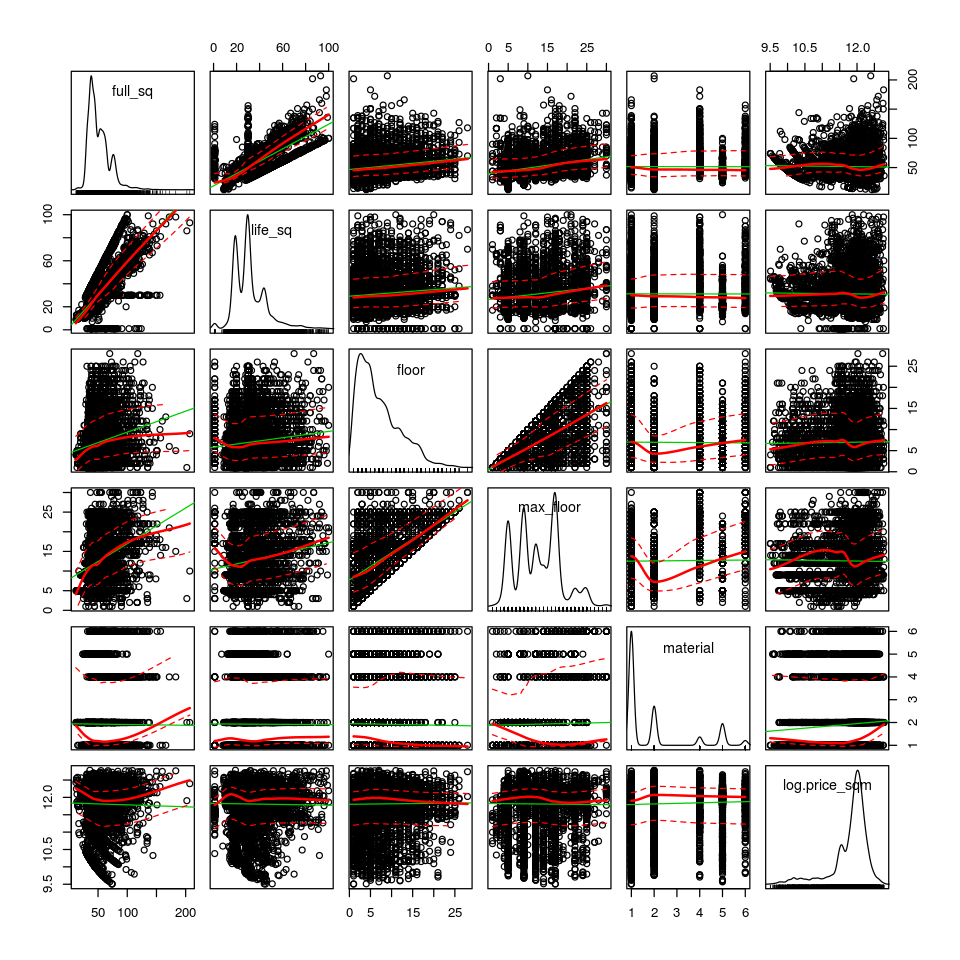

In [8]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  full_sq +
                  life_sq +
                  floor +
                  max_floor +
                  material +
                  log.price_sqm,
                  data = real_estate)

The rightmost column and and bottom row show relationships to log of the price per square foot (our target variable). The regression lines are all pretty flat, but **material** looks like a potential categorical variable. 

So far ...
- Potential numerics: none
- Potential categoricals: 1
  - material (5 values)
  
Moving on ...

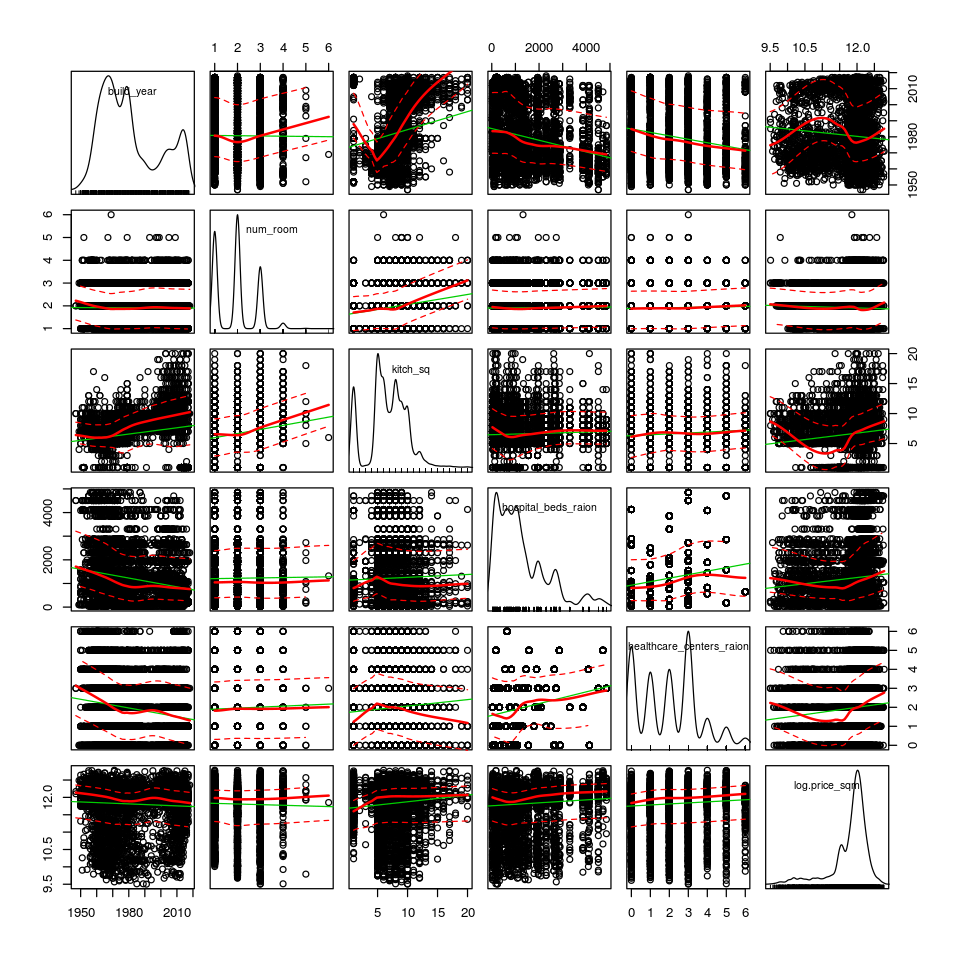

In [9]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  build_year +
                  num_room +
                  kitch_sq +
                  hospital_beds_raion +
                  healthcare_centers_raion +
                  log.price_sqm,
                  data = real_estate)

**build_year**, **kitch_sq** and  **hospital_beds_raion** have some slope; **num_room** and **healthcare_centers_raion** are promising categoricals.

So far ...
- Potential numerics: 3
    - build_year
    - kitch_sq
    - hospital_beds_raion 
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next-up: state, office, metro stations

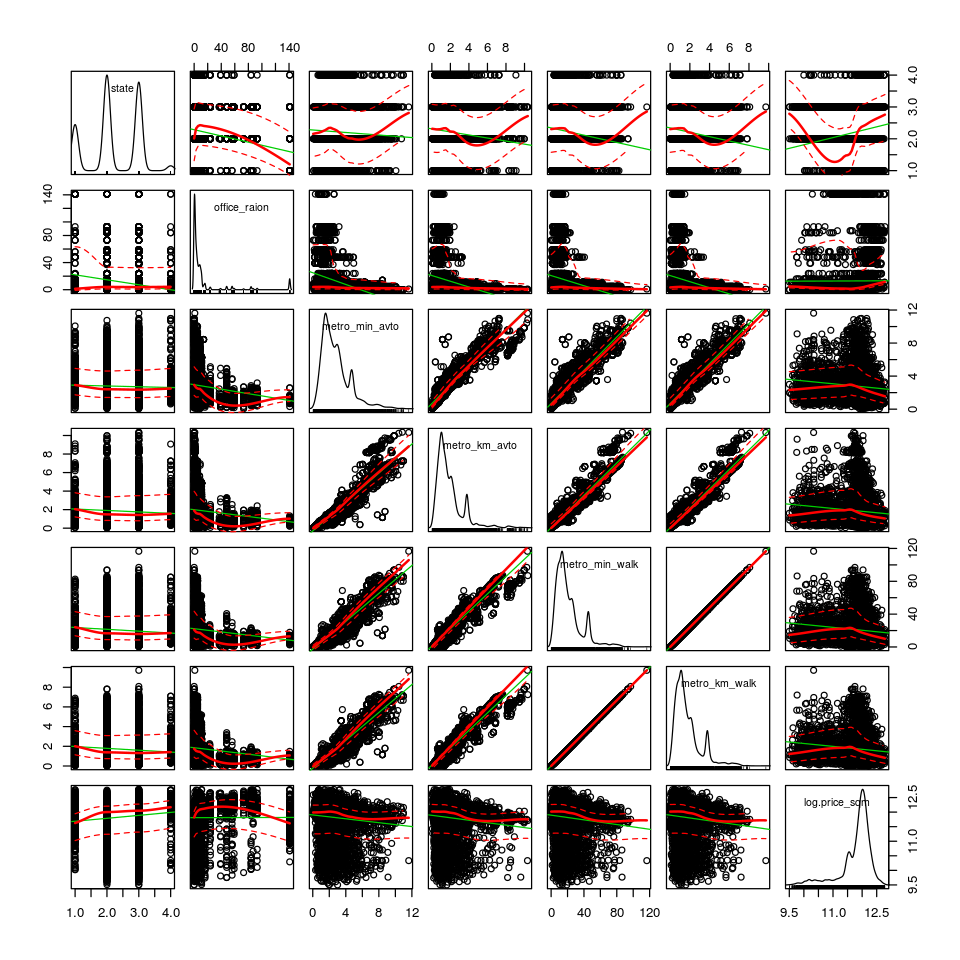

In [10]:
scatterplotMatrix(~ 
                 state +
                  office_raion   +
                  metro_min_avto +
                  metro_km_avto  +
                  metro_min_walk +
                  metro_km_walk +
                  log.price_sqm,
                  data = real_estate)

**state** is a promising categorical. The various **metro** params look similar, so we'll just pick one (**metro_km_walk**)

So far ...
- Potential numerics: 5
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next-up: railroad stations

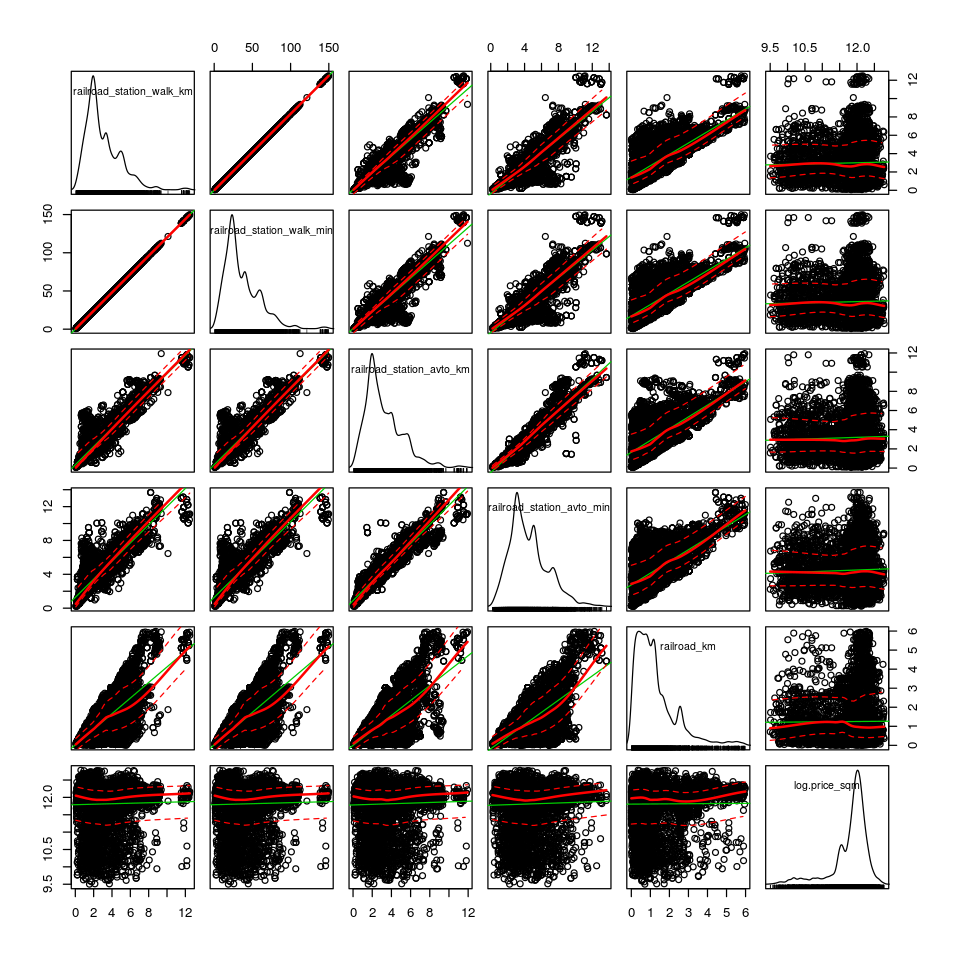

In [11]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                    railroad_station_walk_km          +
                    railroad_station_walk_min         +
                    railroad_station_avto_km          +
                    railroad_station_avto_min         +
                   railroad_km                      +
                  log.price_sqm,
                  data = real_estate)

Similar story to the  **metro** series. Regression lines are all flat, so we'll skip these. 

So far ...
- Potential numerics: 5
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next-up: public transpot, roads, a few others.

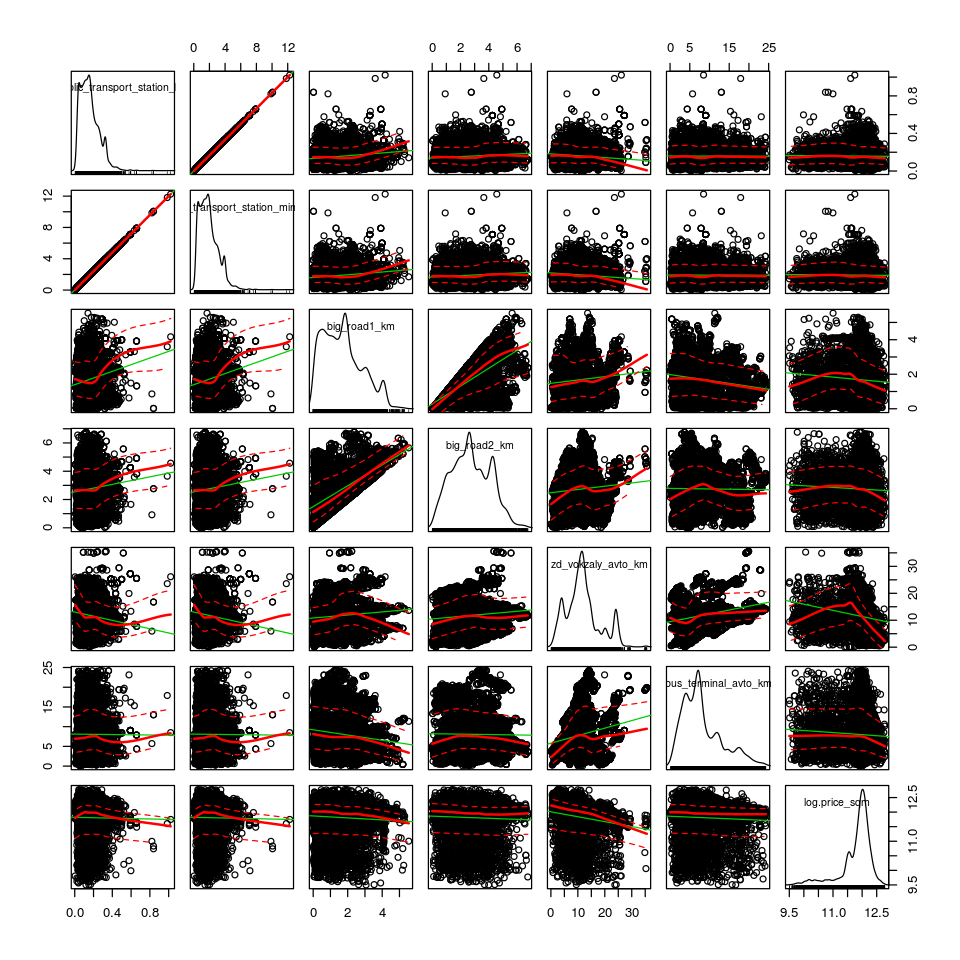

In [12]:
scatterplotMatrix(~ 
                public_transport_station_km       +
                public_transport_station_min_walk +
                big_road1_km                     +
                big_road2_km                     +
                zd_vokzaly_avto_km               +
                bus_terminal_avto_km             +
                  log.price_sqm,
                  data = real_estate)

**zd_vokzaly_avto_km** has a nice slope.

So far ...
- Potential numerics: 6
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next up: oil, hospic, detention, public healthcare

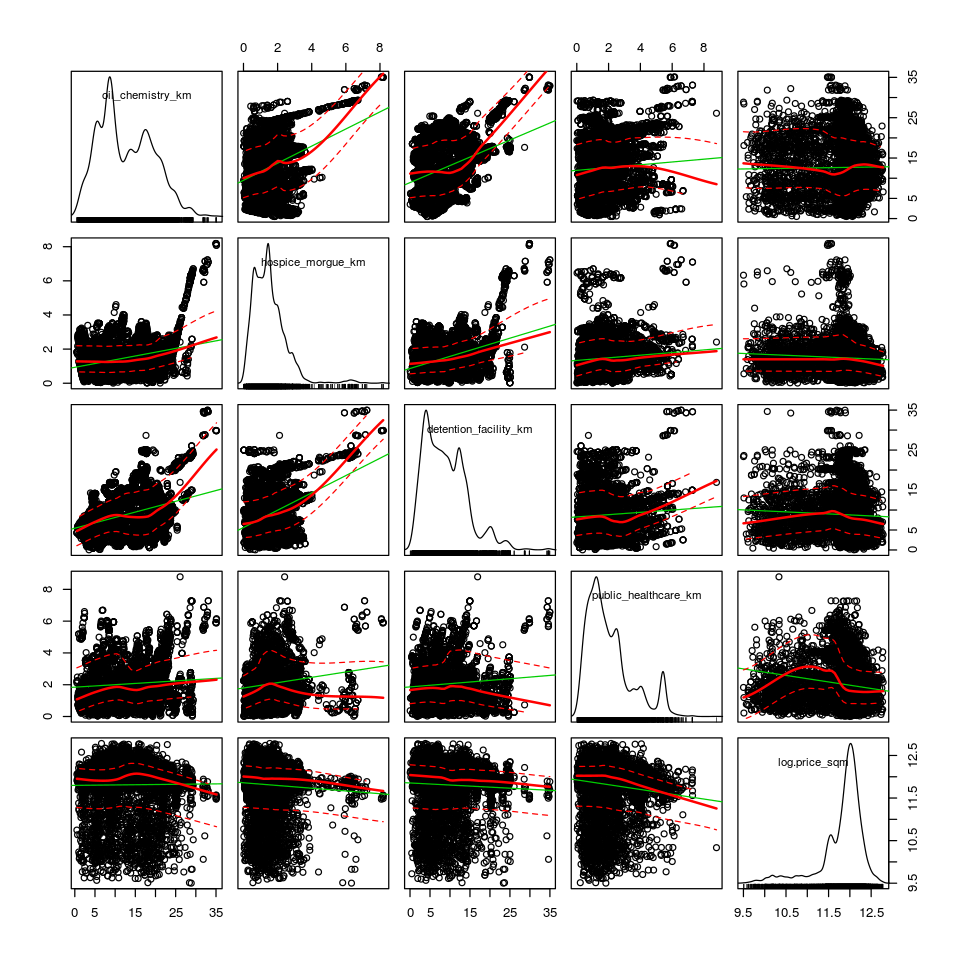

In [13]:
scatterplotMatrix(~ 
                oil_chemistry_km                 +
                hospice_morgue_km                +
                detention_facility_km            +
                public_healthcare_km             +
                  log.price_sqm,
                  data = real_estate)

**public_healthcare_km** has some slope.

So far ...
- Potential numerics: 7
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next up: offices

Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”

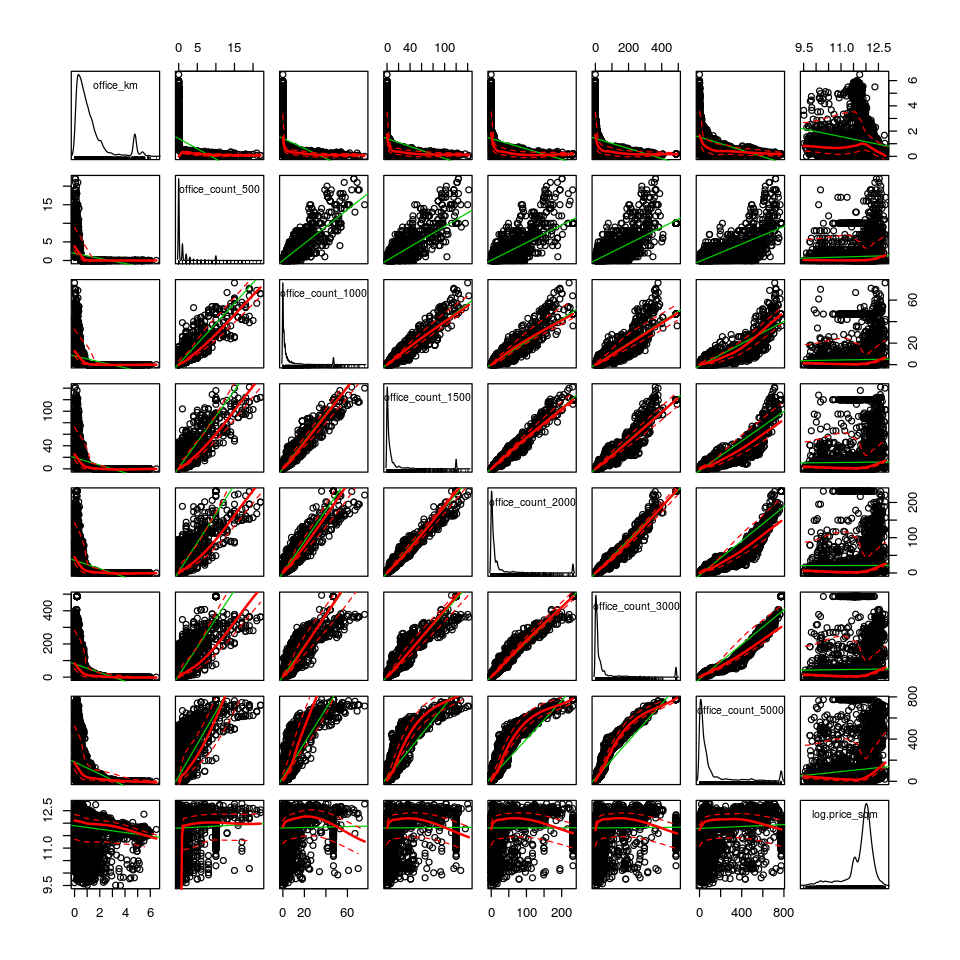

In [14]:
scatterplotMatrix(~ 
                office_km                        +
                office_count_500                 +
                office_count_1000                +
                office_count_1500                +
                office_count_2000                +
                office_count_3000                +
                office_count_5000                +
                  log.price_sqm,
                  data = real_estate)

**office_km** has some slope.

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next up: promenades

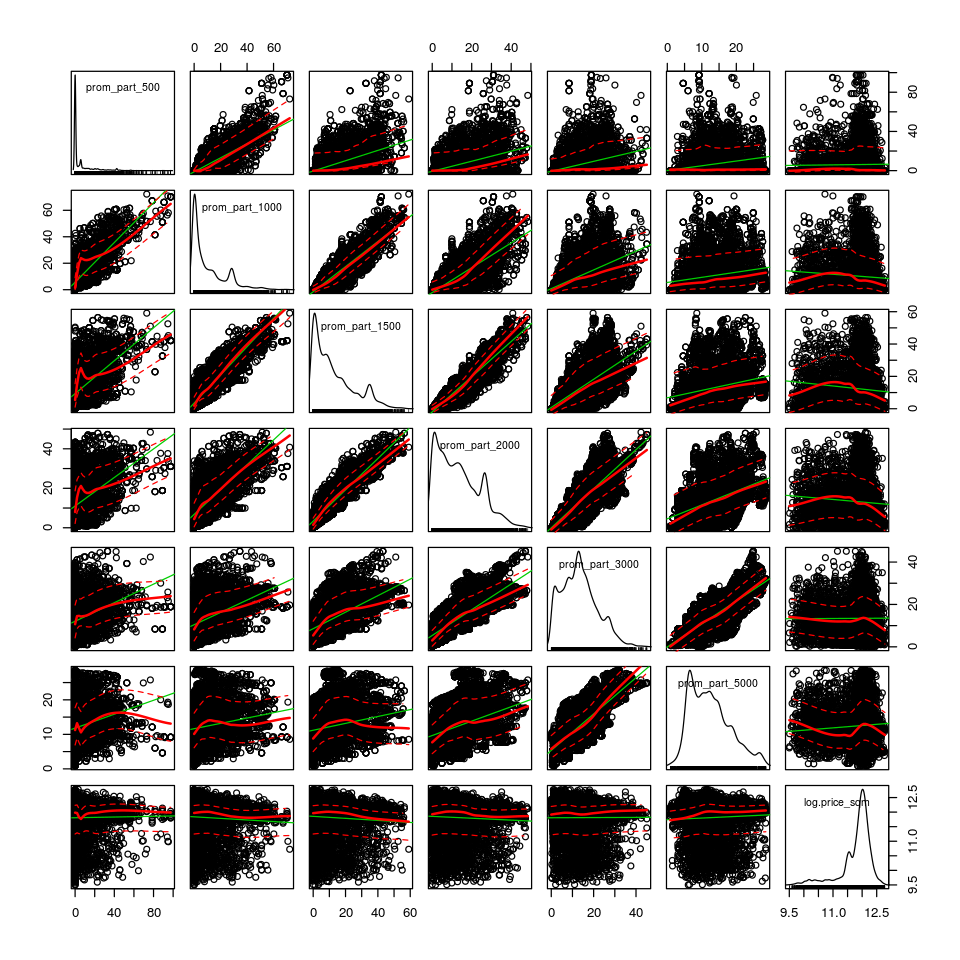

In [15]:
scatterplotMatrix(~ 
                  prom_part_500                    +
                  prom_part_1000                   +
                  prom_part_1500                   +
                  prom_part_2000                   +
                  prom_part_3000                   +
                  prom_part_5000                   +

                  log.price_sqm,
                  data = real_estate)

Best slope seems to be out of **prom_part_1500** 

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
    - prom_part_1500
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next up: yearbuilt, year sold, and others

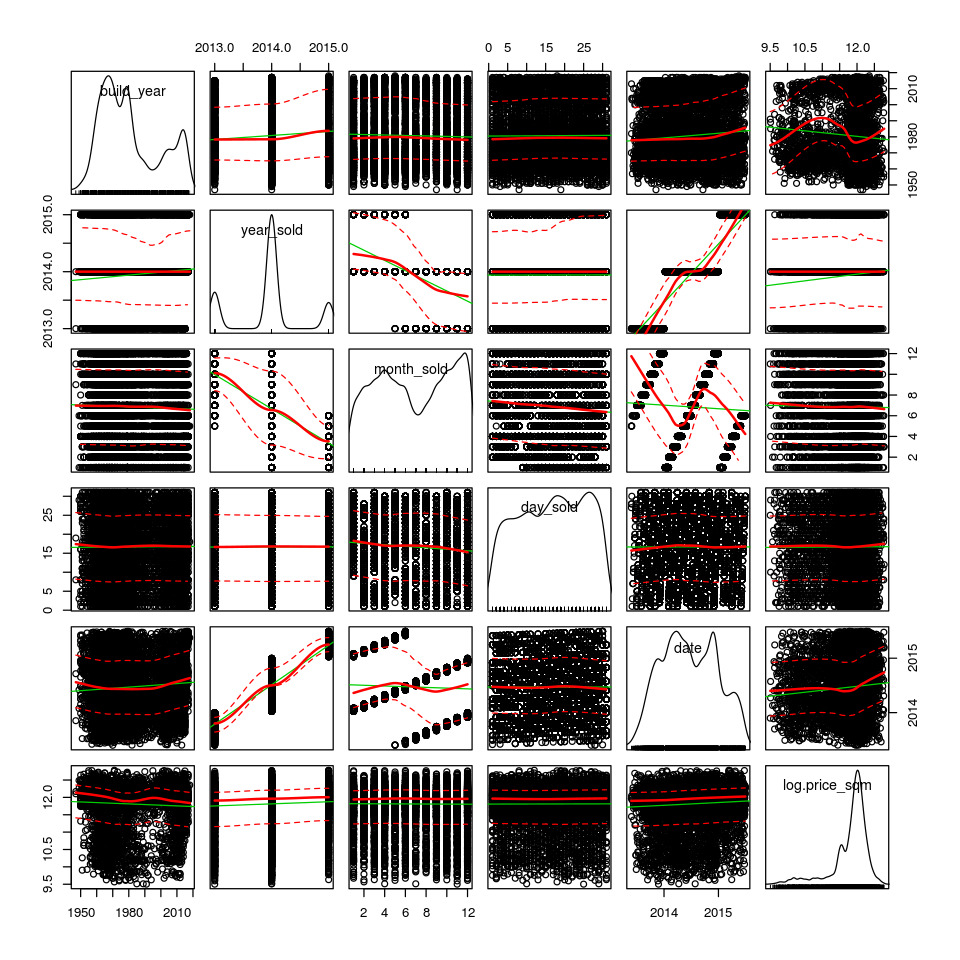

In [16]:
scatterplotMatrix(~ 
                  build_year +
                  year_sold +
                  month_sold +
                  day_sold +
                  date +
                  log.price_sqm,
                  data = real_estate)

**year_sold** has potential as a categorical, **month_sold** suggests some seasonality.

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
    - prom_part_1500
- Potential categoricals: 4
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)
  - year_sold (3 values)
  - month_sold (12 values)

Next-up: Look at what we got

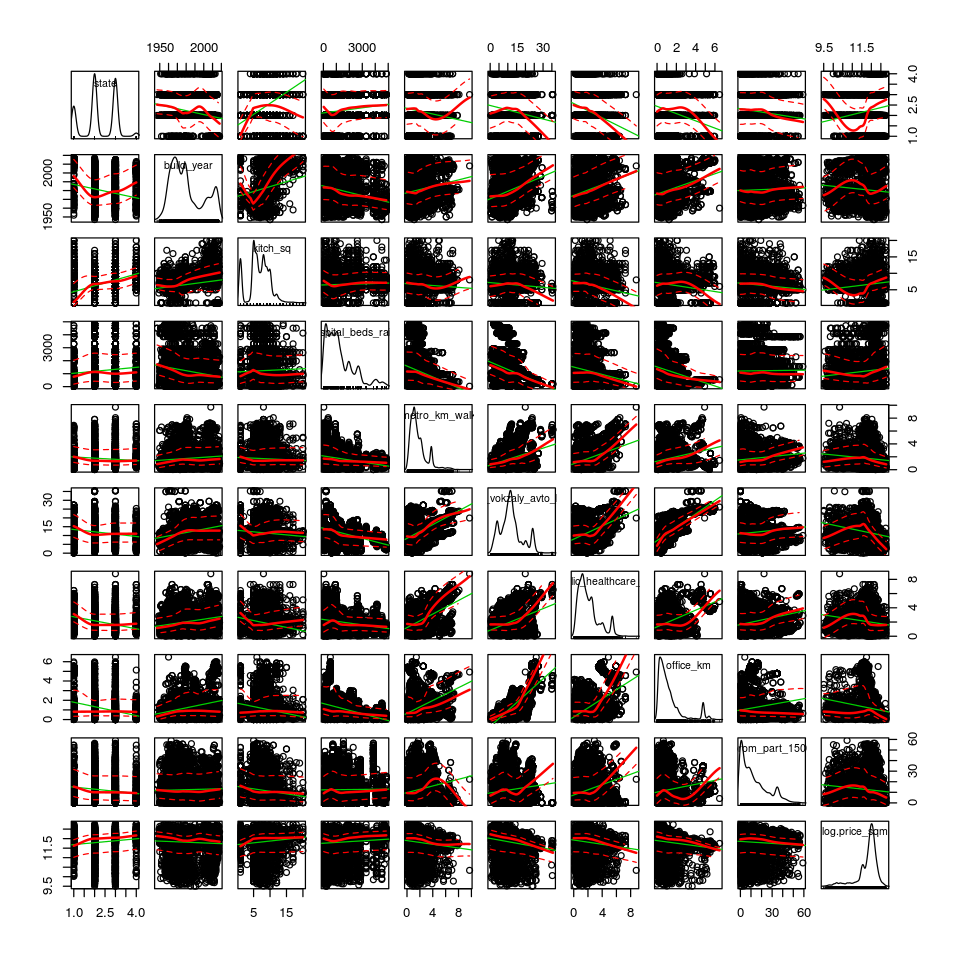

In [17]:
scatterplotMatrix(~ 
                  state +
                  build_year +
                  kitch_sq +
                  hospital_beds_raion +
                  metro_km_walk +
                  zd_vokzaly_avto_km +
                  public_healthcare_km +
                  office_km +
                  prom_part_1500 +
                  log.price_sqm,
                  data = real_estate)

It's imortant to note how _non-linear_ all the scatterplots are when **log.price_sqm** is involved. Before we model, we have to find a way to extract a subset. 

## Slice, Dice, and Extract

Okay, we've trimed 70 features down to 13, but they're all pretty noisy. 

- **8 Potential numerics:** state, build_year, kitch_sq, hospital_beds_raion, metro_km_walk, zd_vokzaly_avto_km, public_healthcare_km, prom_part_1500

- ** 5 Potential categoricals:**, material (5 values), num_room (5 values), healthcare_centers_raion (7 values), year_sold (3 values), month_sold (12 values)

Let's look closer at how they relate to price per squre meter and see if we can "bucketize" them in some way.

A few helperfunctions to simplify plotting.

In [67]:
plot.violin <- function(df, xvar, title){
    options(repr.plot.width=12, repr.plot.height=4)
    ggplot(df, aes(x = factor(xvar), y = df$log.price_sqm)) +
    geom_violin(trim = TRUE, draw_quantiles = c(0.25, 0.5, 0.75)) +
    xlab(title) + ylab("log(price/sqm)") + ggtitle(title)
}

plot.violin.vert <- function(df, xvar, title){
    options(repr.plot.width=12, repr.plot.height=4)
    ggplot(df, aes(x = factor(xvar), y = df$log.price_sqm)) +
    geom_violin(trim = TRUE, draw_quantiles = c(0.25, 0.5, 0.75)) +
    xlab(title) + ylab("log(price/sqm)")+ ggtitle(title) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

plot.density.2d = function(df, xvar, title){
    ggplot(df, aes(x = xvar, y = df$log.price_sqm,))+  
    geom_density2d() +
    xlab(title) + ylab("log(price/sqm)")+ ggtitle(title)
}

### Start with State

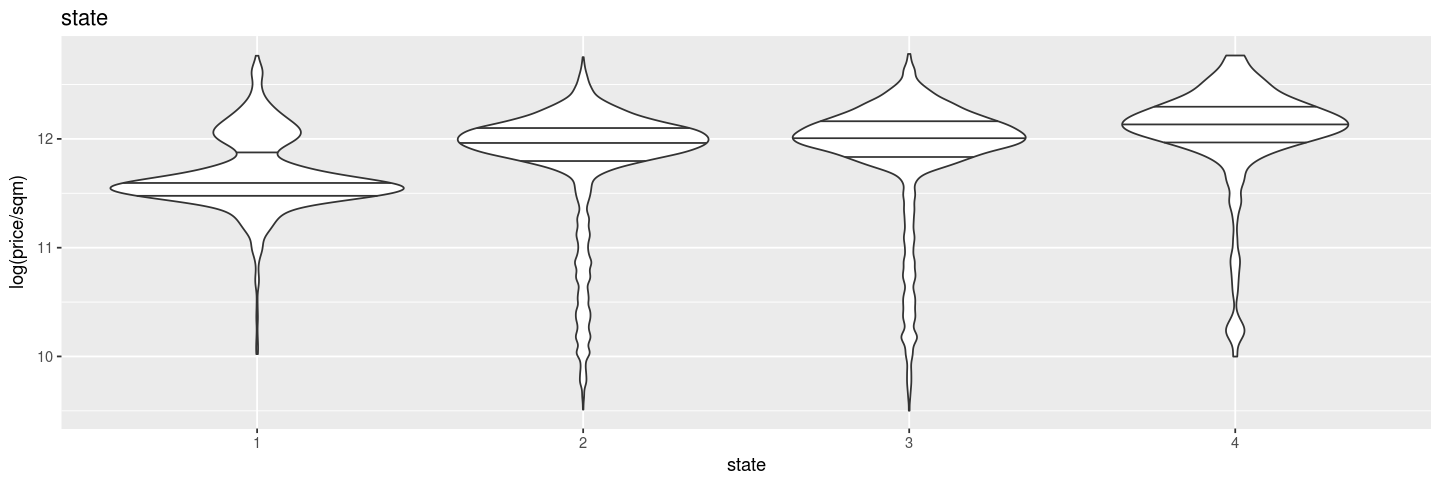

In [68]:
plot.violin(real_estate, real_estate$state, "state")

The violin plot suggests we could have one bucket with state=1, and another with state=2-4.

 Trying a 2d denisity plot ...

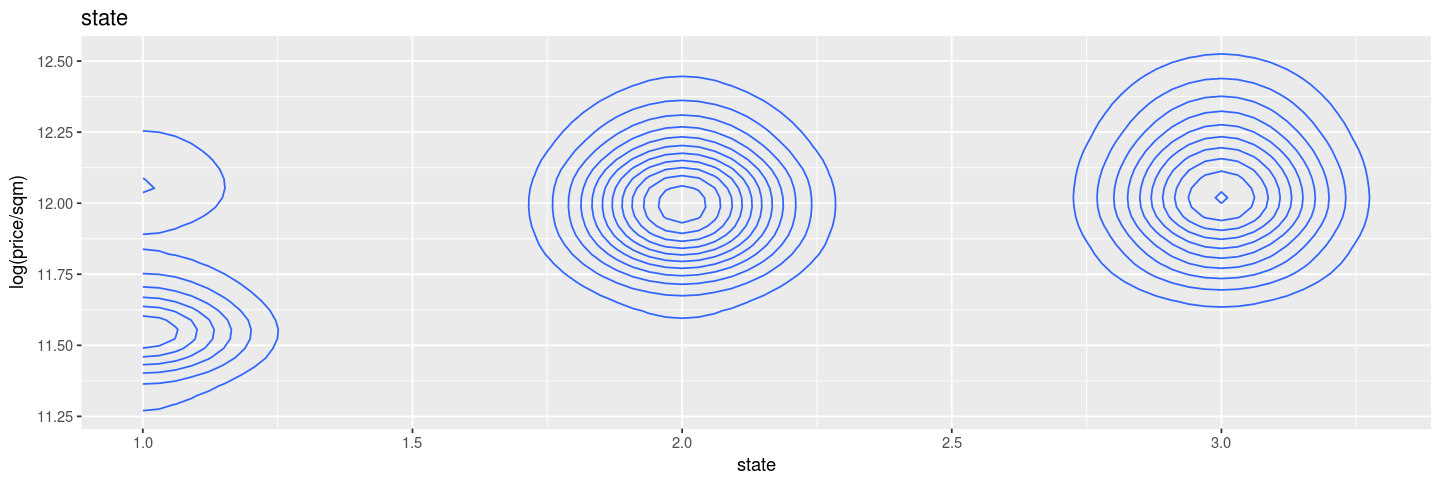

In [64]:
plot.density.2d(real_estate, real_estate$state, "state")

... tells us the same story. Time to start keeping notes:

Bucketizing notes
- **state:** one bucket for state <=1; one for everything else.

### Next up: build year.  
There's going to be lots os possible years, so we'll go straight to the 2d density plot.

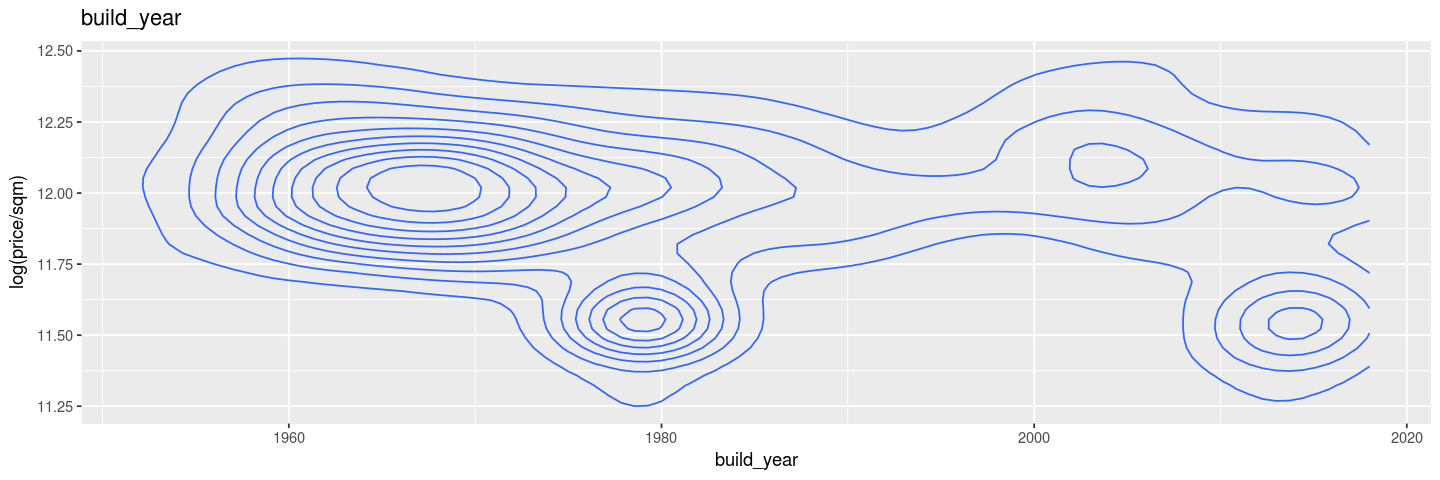

In [65]:
plot.density.2d(real_estate, real_estate$build_year, "build_year")

We're basically looking for ways to draw horizontal lines across the plot to split the contours into "islands."  In this case, you can draw a line at price per sq. m = 11.75. From the vertical point of view, we can get the split we want by separating build year into one bucket for 1970-1990 as well as 2010-2020, and one for everything else.

Update our notes:

Bucketizing notes
- **state:** one bucket for state <=1; one for everything else.
- **build_year:** 
    - one bucket for 1975-1990; 2010-2020
    - one bucket for everything else

### Next up: Kitchen Space, Square Meters.

Try a violin plot.

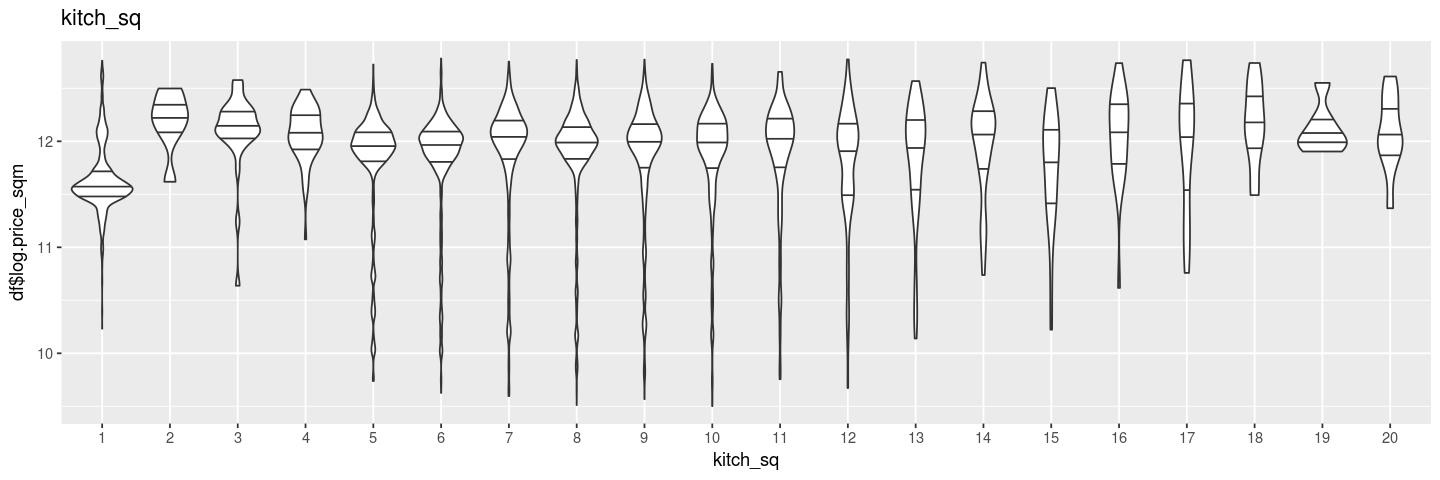

In [27]:
plot.violin(real_estate, real_estate$kitch_sq, "kitch_sq")

That's a lot, switch to 2D density plot.

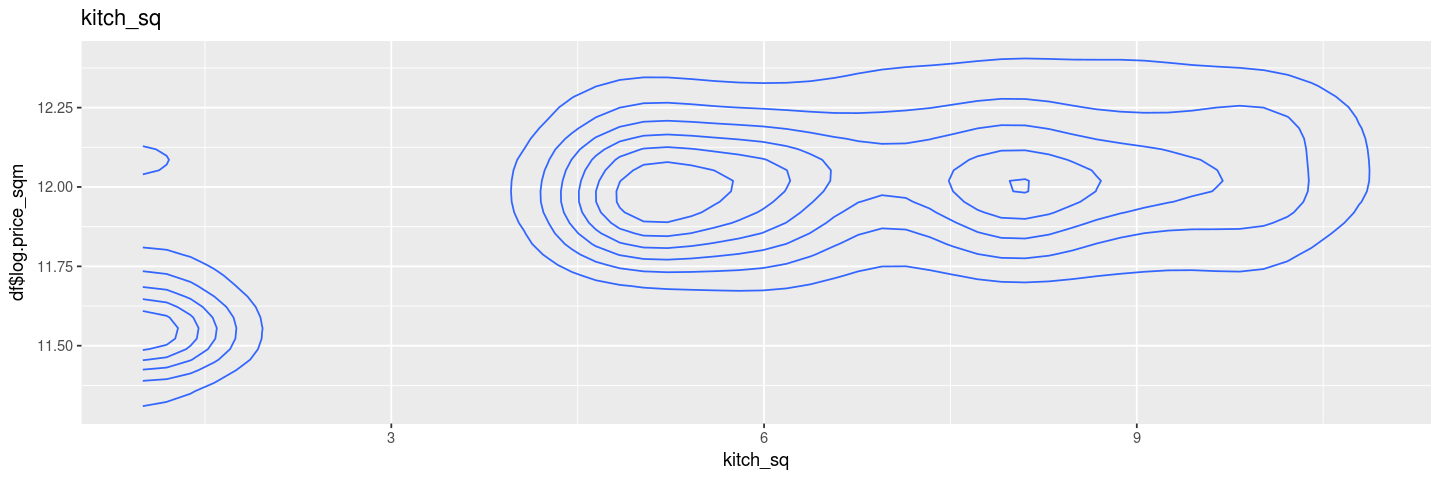

In [28]:
plot.density.2d(real_estate, real_estate$kitch_sq, "kitch_sq")

Much easier to work with. We can get 2 clean-ish buckets if we split where kitch_sq = 3. Update our ntoes.

Bucketizing notes
- **state:** one bucket for state <=1; one for everything else.
- **build_year:** 
    - one bucket for 1975-1990; 2010-2020
    - one bucket for everything else
- **kitch_sq:** one bucket for kitch_sq <=3; one for everything else.

### Next up: Hospital Beds.
This is another feature with many values, so we'll go to the density plot.'

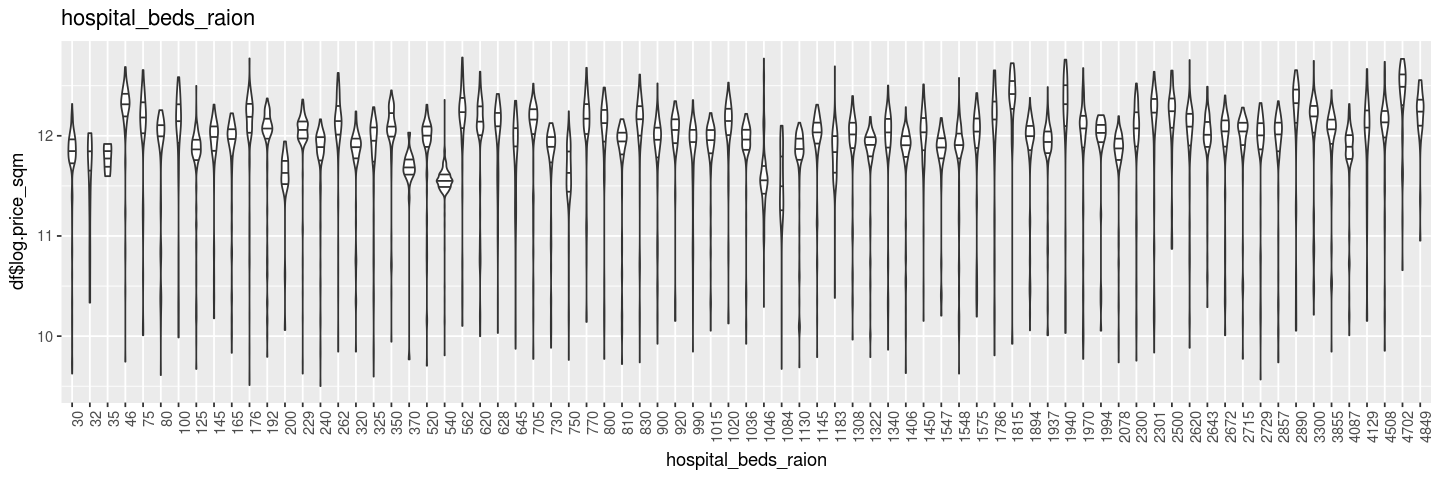

In [29]:
plot.violin.vert(real_estate, real_estate$hospital_beds_raion, "hospital_beds_raion")

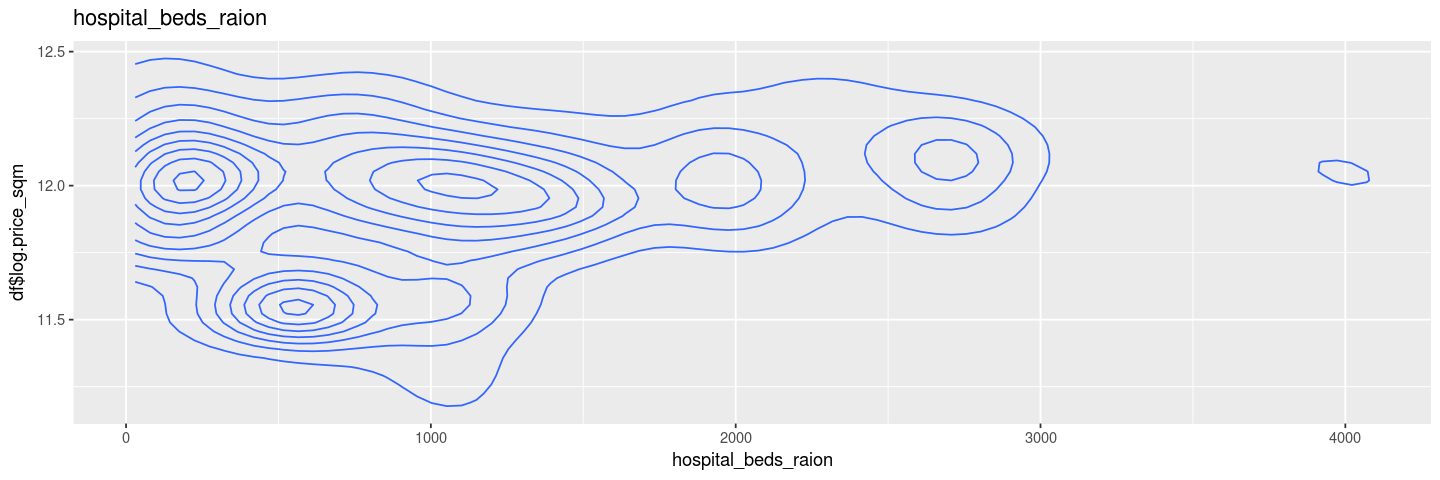

In [30]:
plot.density.2d(real_estate, real_estate$hospital_beds_raion, "hospital_beds_raion")

2D Density Notes
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

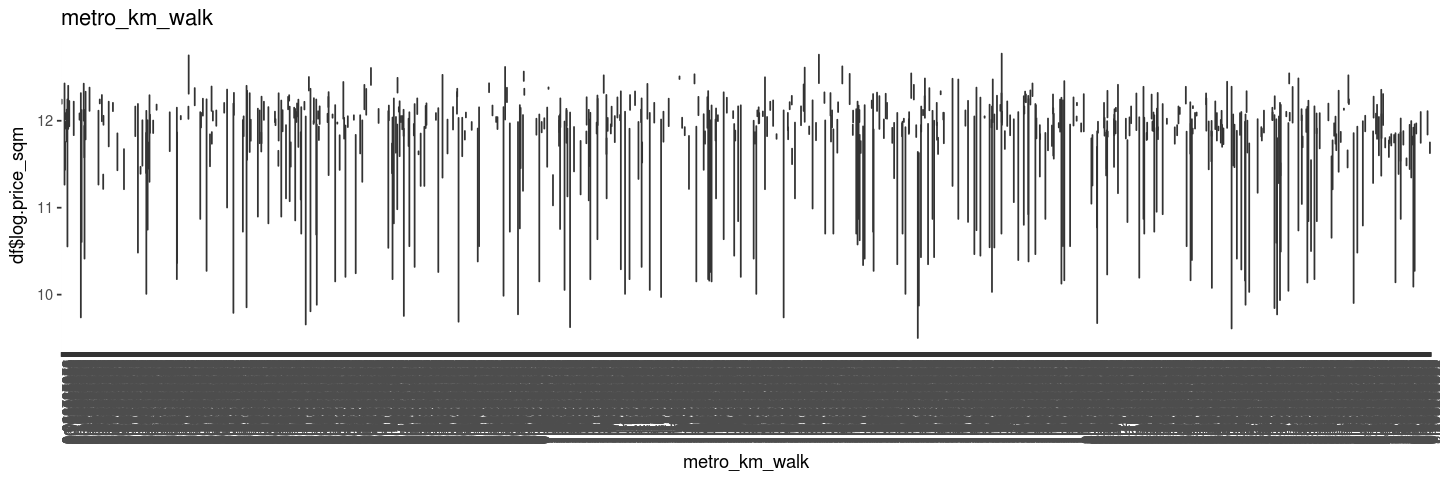

In [31]:
plot.violin.vert(real_estate, real_estate$metro_km_walk, "metro_km_walk")

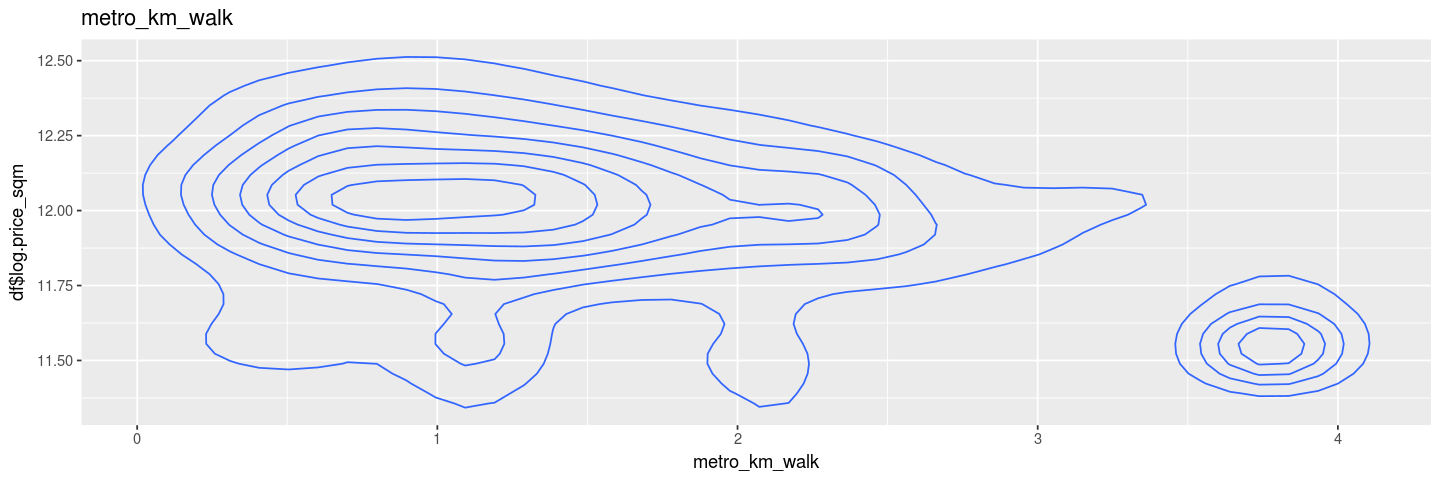

In [32]:
plot.density.2d(real_estate, real_estate$metro_km_walk, "metro_km_walk")

2D Density Notes
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

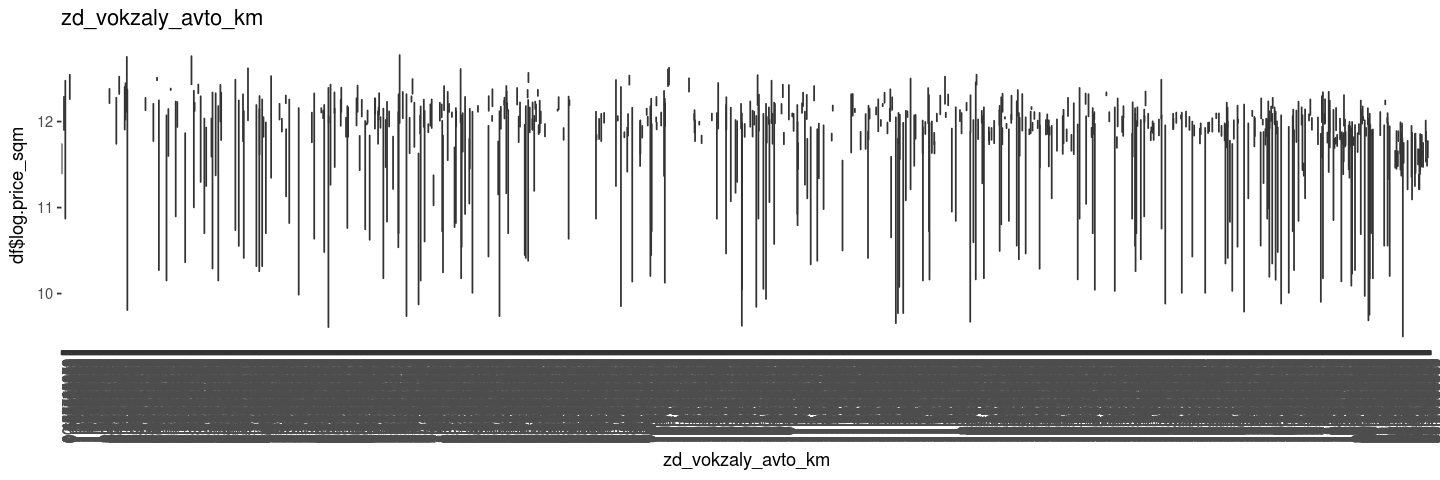

In [33]:
plot.violin.vert(real_estate, real_estate$zd_vokzaly_avto_km, "zd_vokzaly_avto_km")

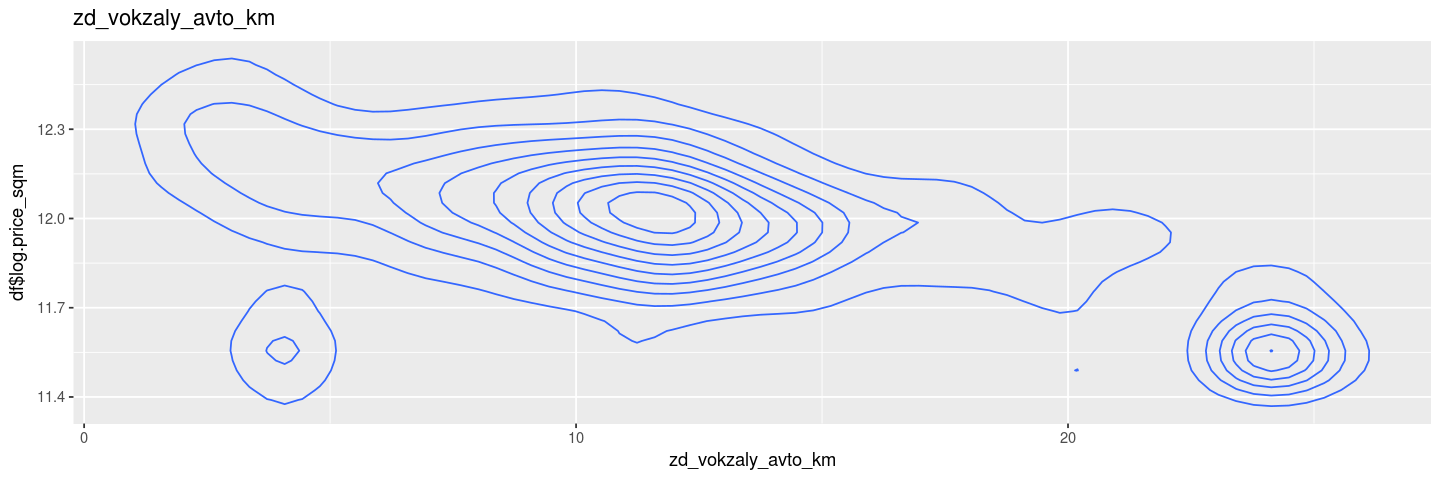

In [34]:
plot.density.2d(real_estate, real_estate$zd_vokzaly_avto_km, "zd_vokzaly_avto_km")

2D Density Notes
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

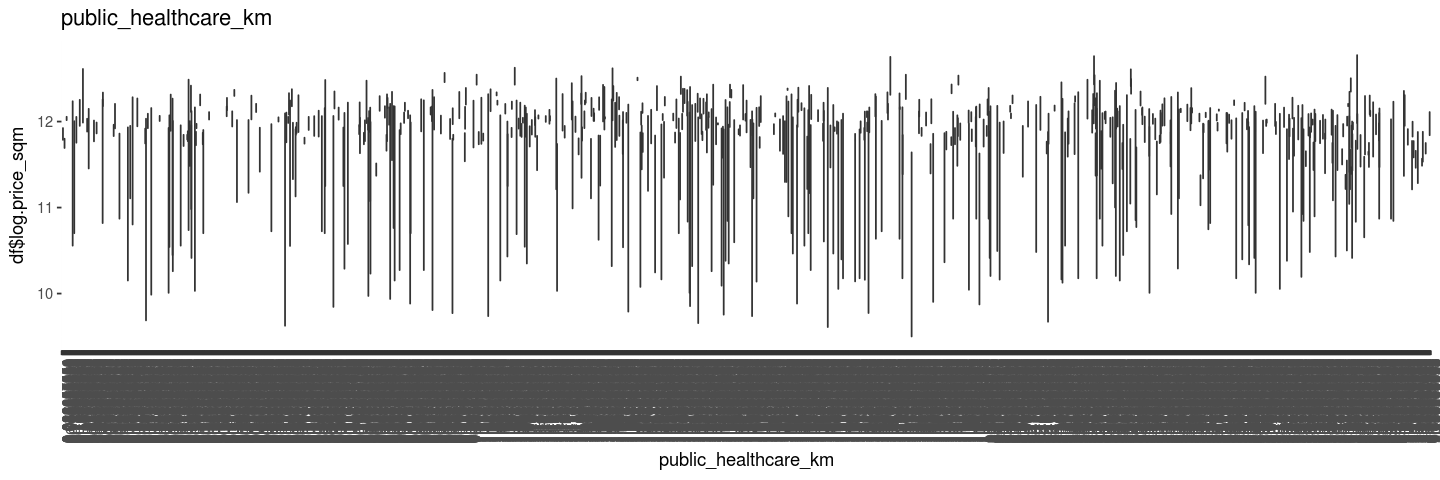

In [35]:
plot.violin.vert(real_estate, real_estate$public_healthcare_km, "public_healthcare_km")

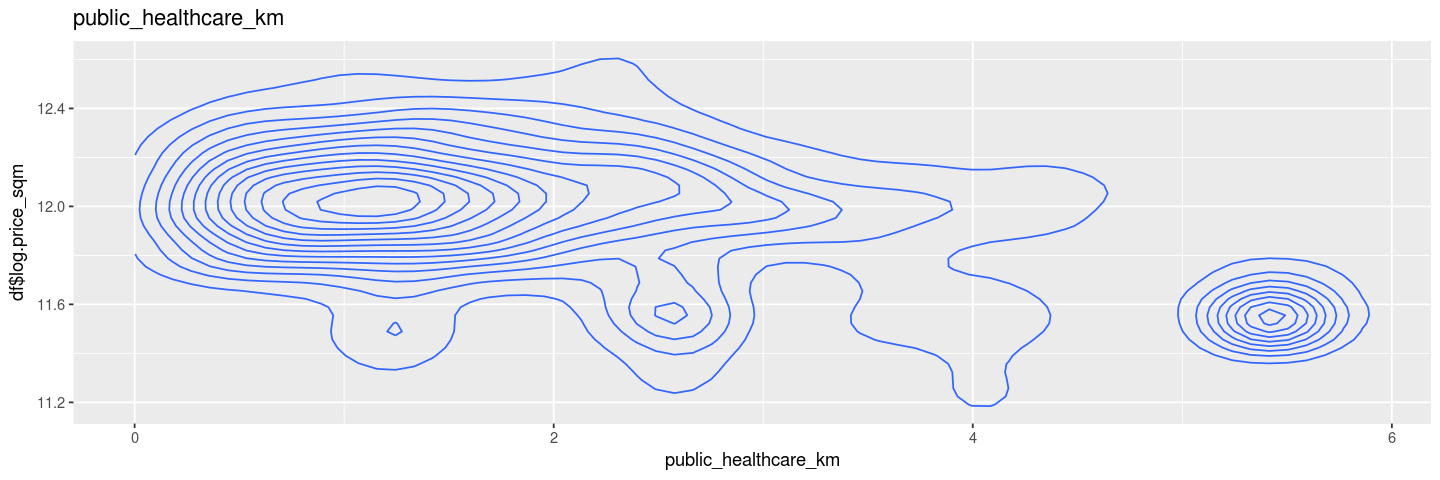

In [36]:
plot.density.2d(real_estate, real_estate$public_healthcare_km, "public_healthcare_km")

2D Density Notes
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

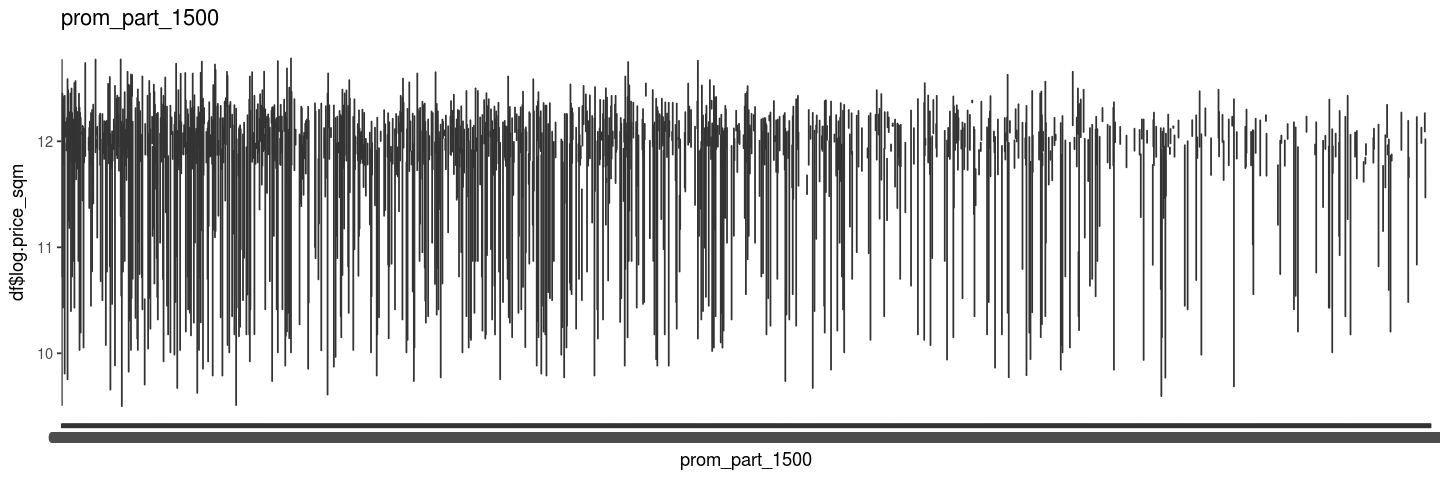

In [37]:
plot.violin(real_estate, real_estate$prom_part_1500, "prom_part_1500")

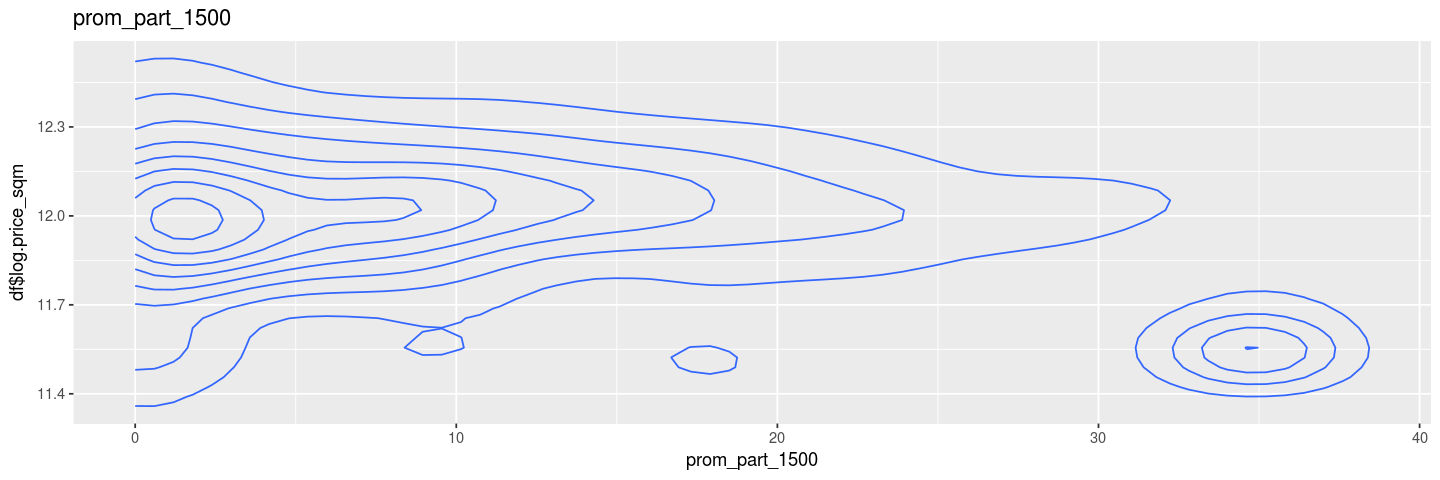

In [38]:
plot.density.2d(real_estate, real_estate$prom_part_1500, "prom_part_1500")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

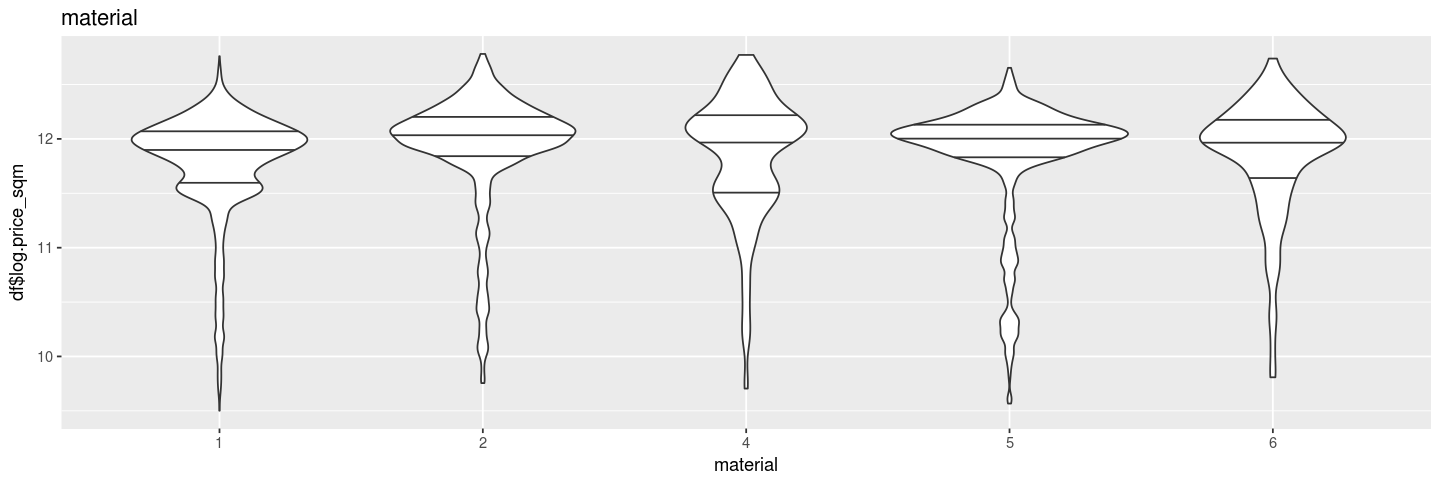

In [39]:
plot.violin(real_estate, real_estate$material, "material")

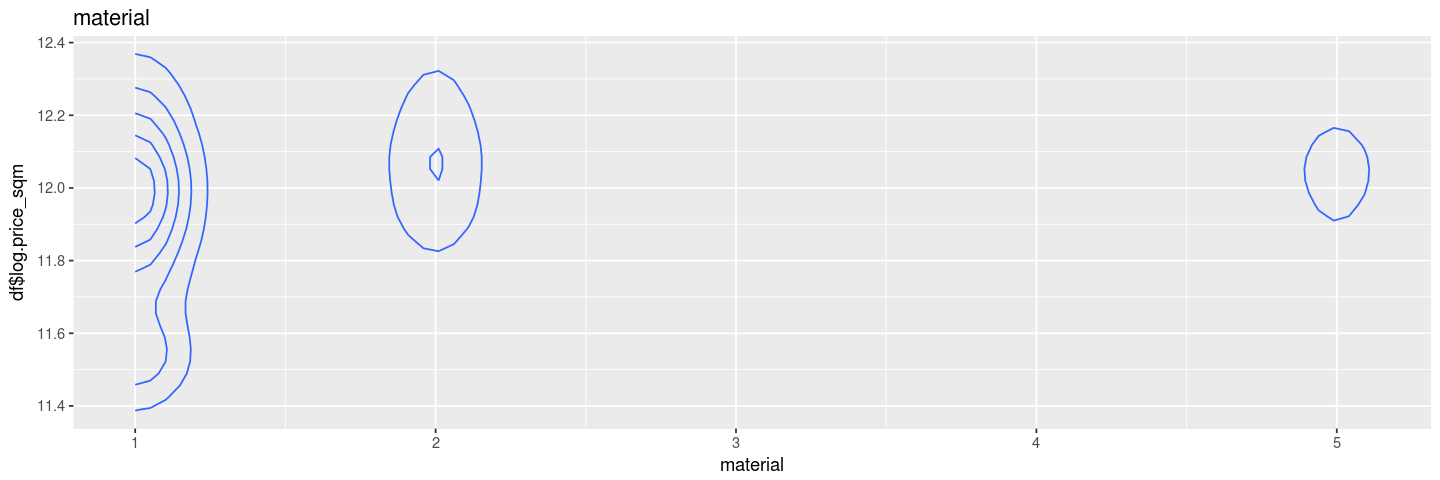

In [40]:
plot.density.2d(real_estate, real_estate$material, "material")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

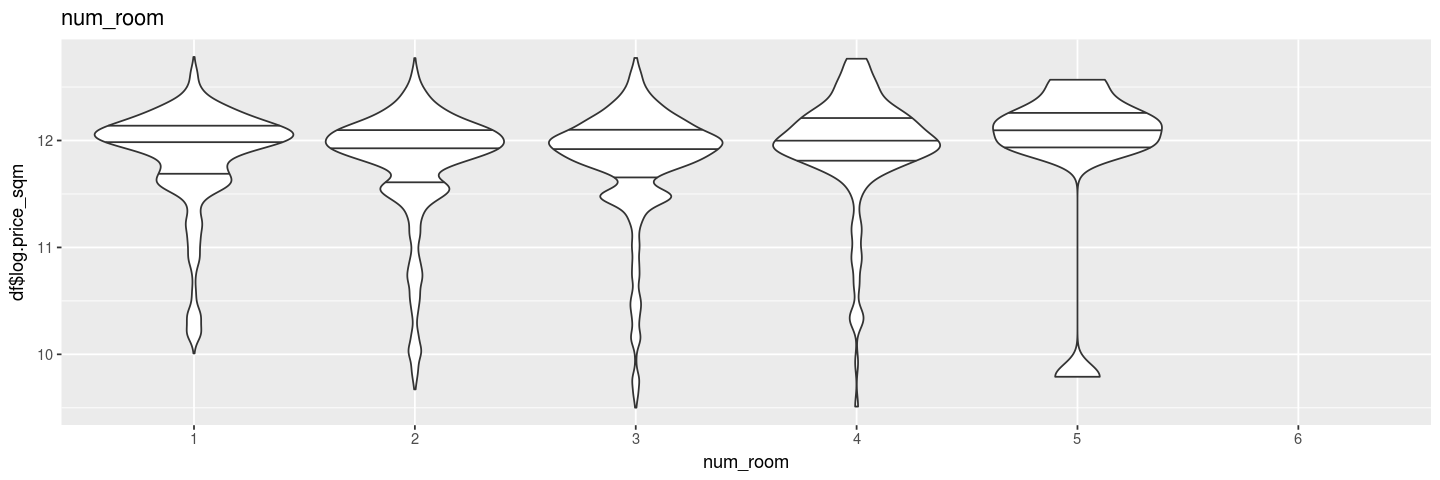

In [41]:
plot.violin(real_estate, real_estate$num_room, "num_room")

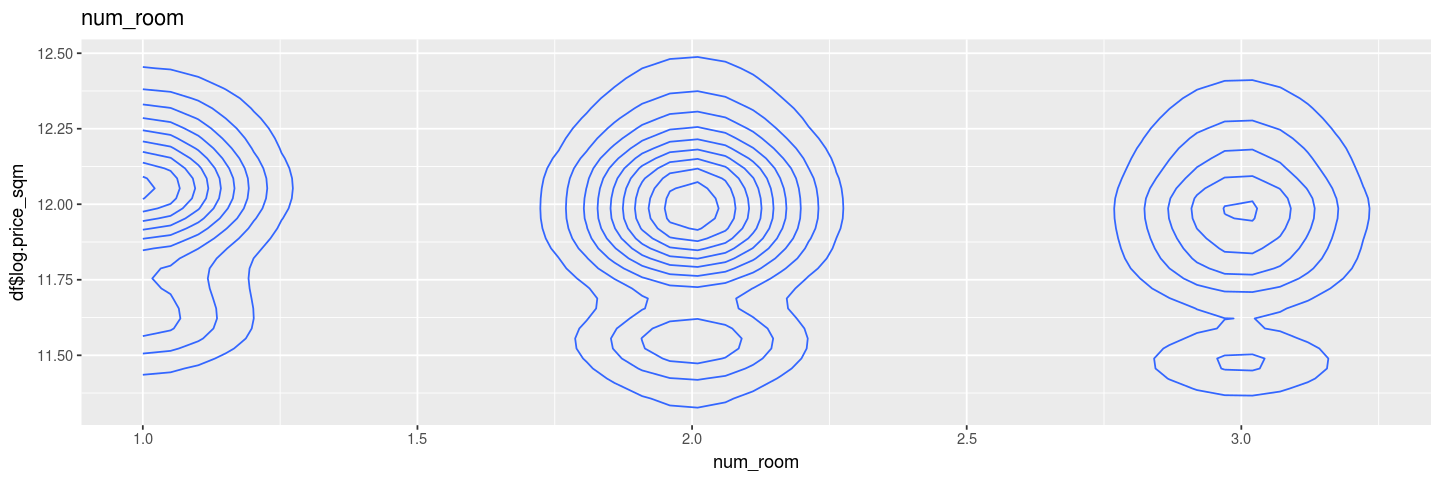

In [42]:
plot.density.2d(real_estate, real_estate$num_room, "num_room")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

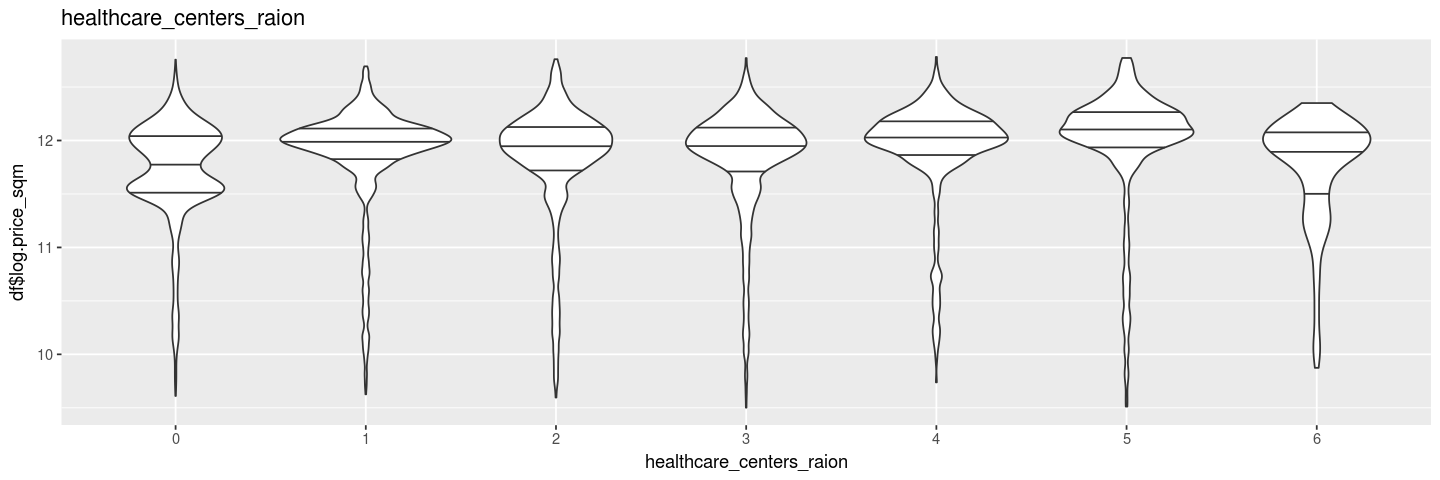

In [43]:
plot.violin(real_estate, real_estate$healthcare_centers_raion, "healthcare_centers_raion")

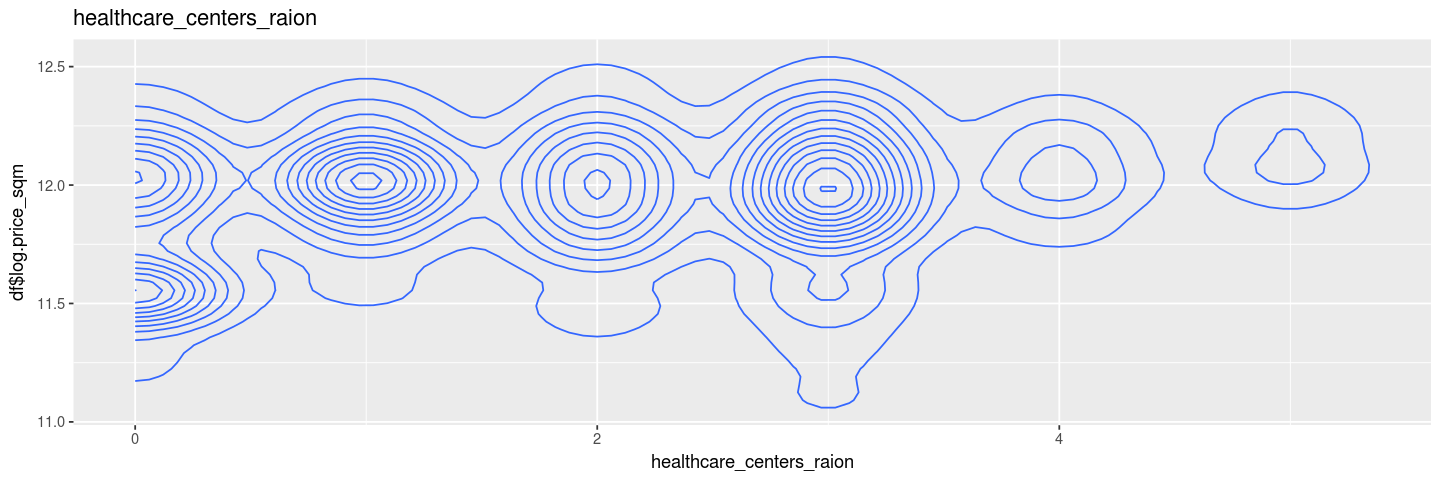

In [44]:
plot.density.2d(real_estate, real_estate$healthcare_centers_raion, "healthcare_centers_raion")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

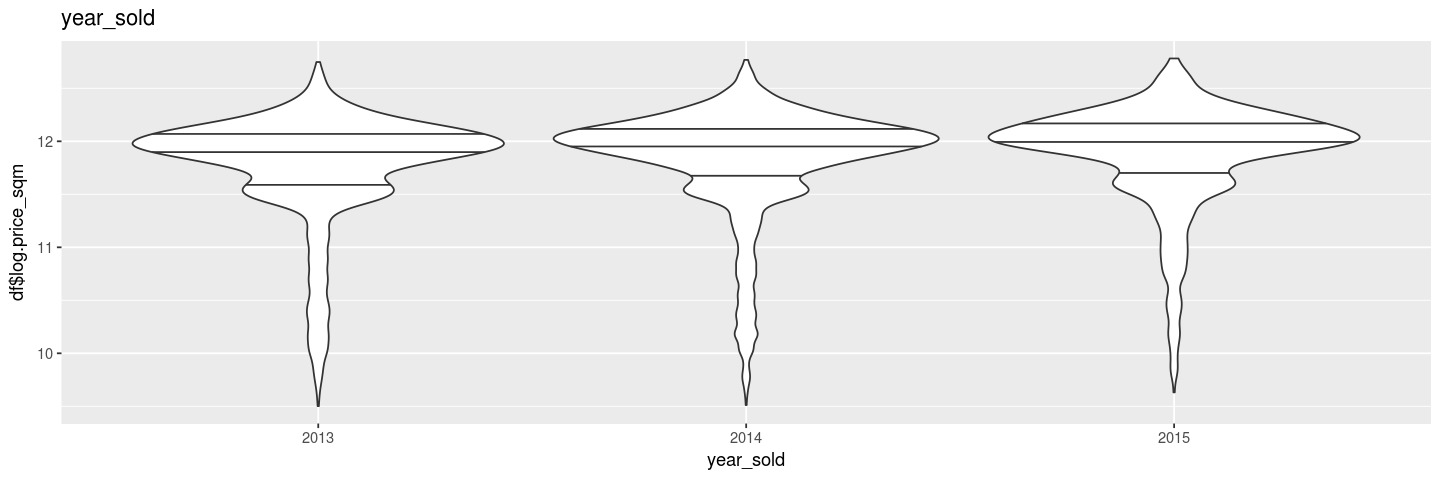

In [45]:
plot.violin(real_estate, real_estate$year_sold, "year_sold")

Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”

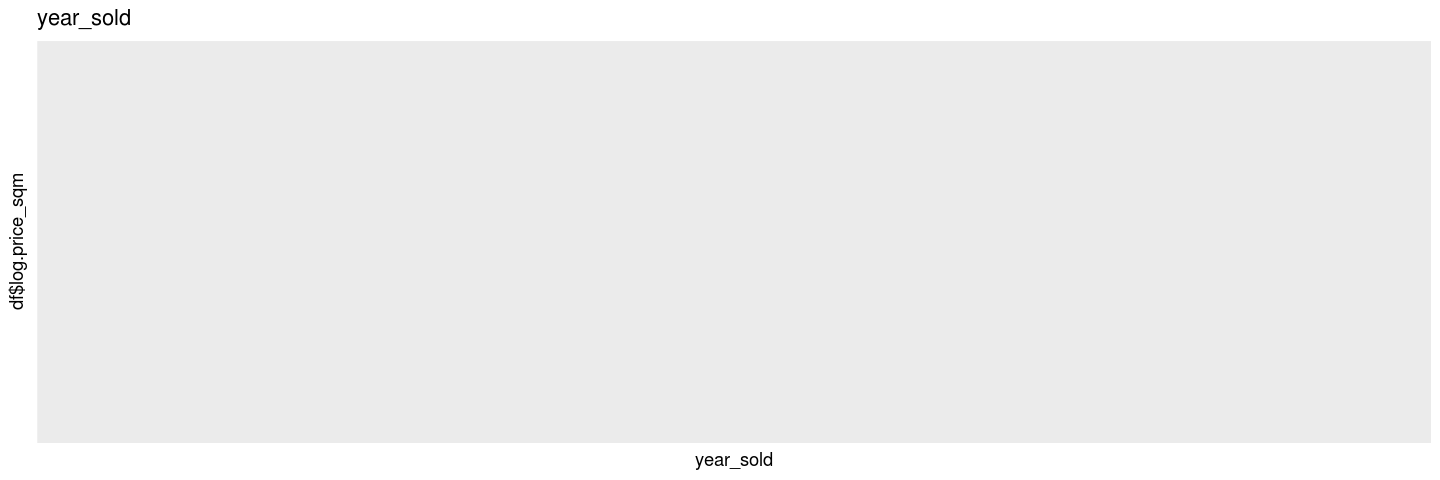

In [46]:
plot.density.2d(real_estate, real_estate$year_sold, "year_sold")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

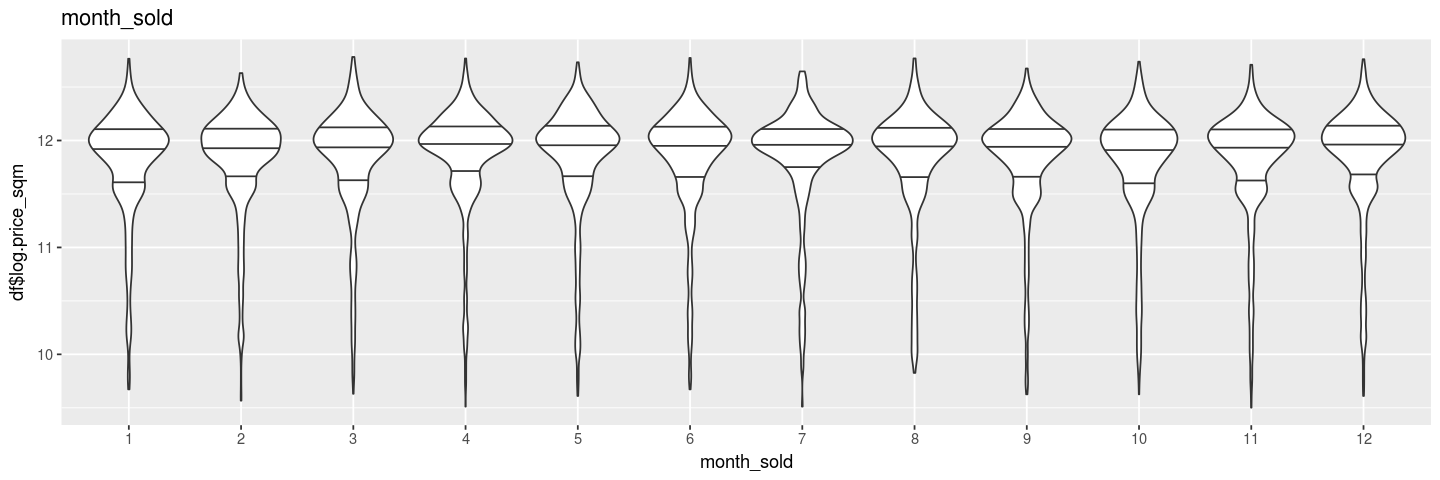

In [47]:
plot.violin(real_estate, real_estate$month_sold, "month_sold")

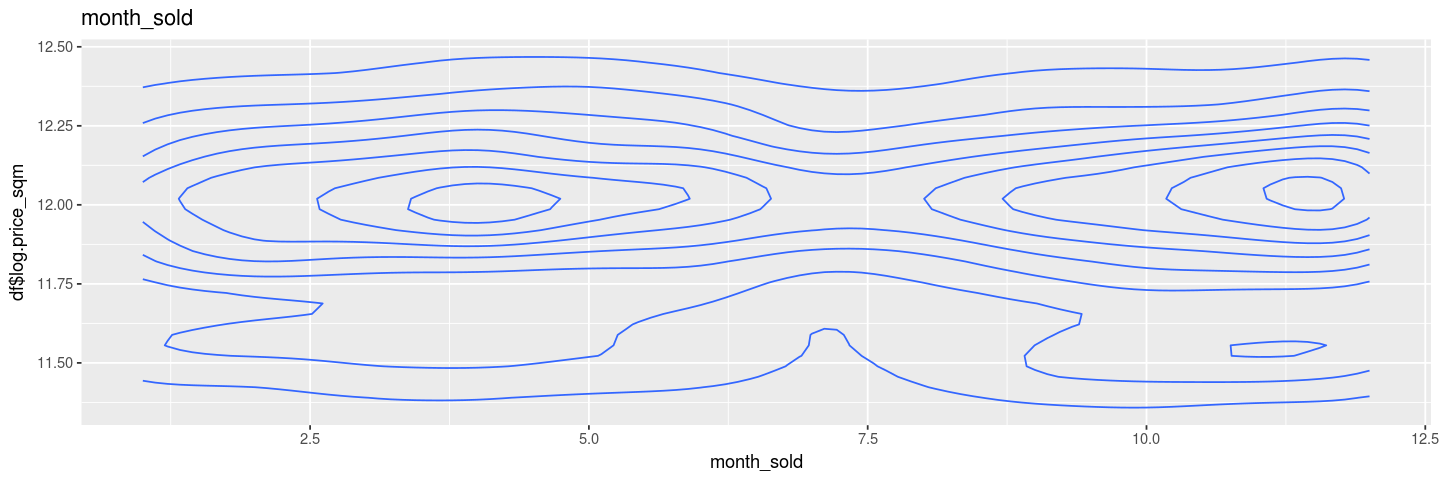

In [48]:
plot.density.2d(real_estate, real_estate$month_sold, "month_sold")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

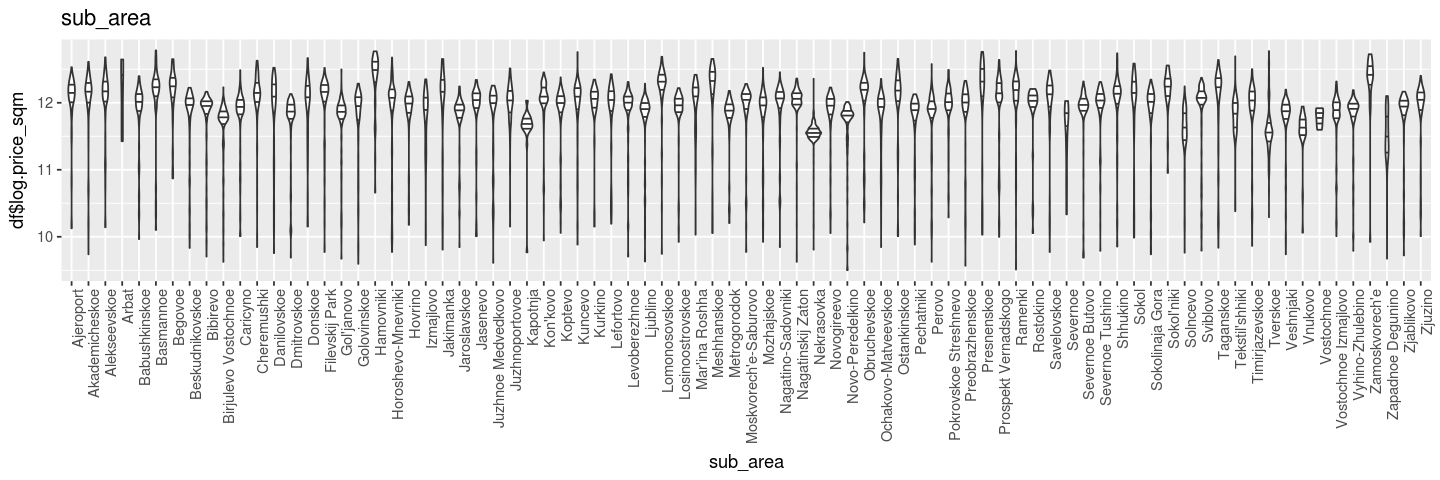

In [49]:
plot.violin.vert(real_estate, real_estate$sub_area, "sub_area")

Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”

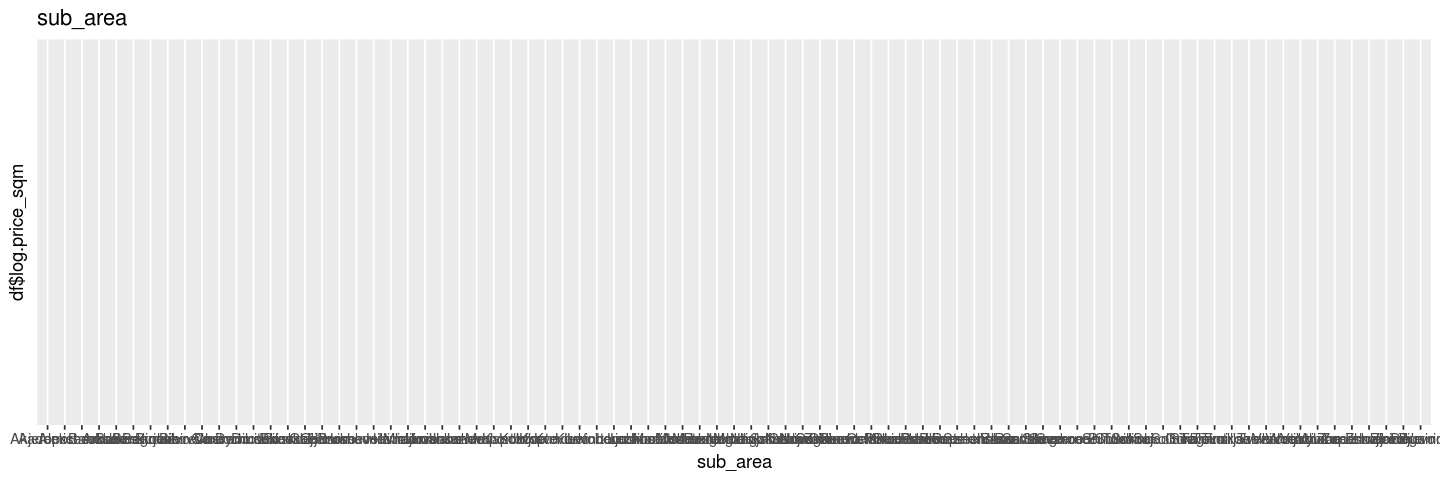

In [50]:
plot.density.2d(real_estate, real_estate$sub_area, "sub_area")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)
- **sub_area: split on (violin only)**
  - Kapotnja, Nekrasovka, Tverskoe, Vnukovo
  - Hamovniki, Zamoskvorech'e, Hamovniki
   - everything else 

## We've got our Buckets, now let's extract

In [51]:
# RESUME HERE


In [62]:
#This hould sbe movde
real_estate$century = ifelse(real_estate$build_year < 2000, 20, 21)

In [52]:
real_estate$year_buckets = 
    ifelse(real_estate$build_year < 1979 1, 1, 0)
real_estate$year_buckets = 
    ifelse((real_estate$build_year == 1979 1) & 
           (real_estate$year_buckets == 0), 
           2, 0)
real_estate$year_buckets = 
    ifelse((real_estate$build_year == 1979 1) & 
           (real_estate$year_buckets == 0), 
           2, 0)


ERROR: Error in parse(text = x, srcfile = src): <text>:2:42: unexpected numeric constant
1: real_estate$year_buckets = 
2:     ifelse(real_estate$build_year < 1979 1
                                            ^


In [ ]:
#This should be move
real_estate$state_buckets = ifelse(real_estate$state == 1, 1, 2)



real_estate$two_kitch = ifelse(real_estate$kitch_sq == 1, 1, 2)


## Try some ANOVA

doesn't work
- state
- material


In [ ]:
real_estate.aov = aov(log.price_sqm ~ year_sold, data = real_estate)
summary(real_estate.aov)
options(repr.plot.width=4, repr.plot.height=6)

boxplot(real_estate$log.price_sqm ~ real_estate$year_sold)

## Try some Tukey HSD

In [ ]:
real_estate.hsd = TukeyHSD(real_estate.aov)
real_estate.hsd
options(repr.plot.width=8, repr.plot.height=3)
par (las=2)
par(mar=c(5,10,3,1))
plot(real_estate.hsd)

## Apply a bit of Domain Knowledge
Review the fiends in the dataset

In [ ]:
str(real_estate)

In [ ]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(real_estate, aes(sub_area)) + geom_bar() + coord_flip()

- max_floor less than 10
- one neightborhood Nekrasovka
- built in the 21st century
df[grep("eta", df$Title),]

In [ ]:
areas = c("Nekrasovka")
real_estate.subset = real_estate[grep("Nekrasovka", real_estate$sub_area),]
dim(real_estate)
dim(real_estate.subset)
head(real_estate.subset, 3)
real_estate = real_esate.subset

### Price vs. year built, sliced by Year sold, Rooms, Healthcare centers 

In [ ]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(build_year, log.price_sqm)) +
facet_grid(material ~ state) +
geom_point(aes(color = factor(num_room), 
           size = healthcare_centers_raion,
          shape = factor(year_sold)), 
          alpha = 0.3) +
ggtitle('Relationship between build year and Price, 
  \n faceted by state (columns), and material (rows),
  \n sliced by rooms(color), healthcare centers (size), year sold (shape)')

Seems like we can split by "century" -- properties built in the 1900's vs 2000's

### Price vs. Vokzly, sliced by Year sold, Material, Healthcare centers 

In [ ]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(zd_vokzaly_avto_km, log.price_sqm)) +
facet_grid(material ~ state) +
geom_point(aes(color = factor(month_sold), 
           size = healthcare_centers_raion,
          shape = factor(year_sold)), 
          alpha = 0.3) +
ggtitle('Relationship between build year and Price, 
  \n faceted by state (columns), and material (rows),
  \n sliced by month_sold(color), healthcare centers (size), year sold (shape)')

In [ ]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(full_sq, log.price_sqm)) +
facet_grid(material ~ state) +
geom_point(aes(color = factor(month_sold), 
           size = healthcare_centers_raion,
          shape = factor(year_sold)), 
          alpha = 0.3) +
ggtitle('Relationship between total floorspace and Price, 
  \n faceted by state (columns), and material (rows),
  \n sliced by month_sold(color), healthcare centers (size), year sold (shape)')

Some linear patters for log(Price)<11;  material in {1,2, 5}; state in {2,3}

In [ ]:
# real_estate.subset = subset(real_estate, log.price_sqm<=11 & 
#                            material==5  & state == 3 & build_year < 2000)
real_estate.subset = subset(real_estate,  
                            build_year < 2000)
dim(real_estate)
dim(real_estate.subset)
head(real_estate.subset,3)

In [ ]:
ggplot(real_estate.subset, aes(x = log.price_sqm, y = full_sq,))+ 
geom_point(aes(color = factor(state),
               size = date),
               alpha = 0.3) + 
geom_density2d() +
xlab('log(Price Per Sq Meter)') + 
ylab('Foor space') + 
ggtitle('Price and Floor Space')

## Prune Fields

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
    - prom_part_1500
- Potential categoricals: 5
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)
  - year_sold (3 values)
  - month_sold (12 values)

In [ ]:
keeps = c(
     'build_year',
     'kitch_sq',
     'hospital_beds_raion',
     'metro_km_walk',
     'zd_vokzaly_avto_km',
     'public_healthcare_km',
     'office_km',
     'prom_part_1500',
     'full_sq',
     'num_room',
     'healthcare_centers_raion',
     'year_sold',
     'month_sold',

 'log.price_sqm'
)

real_estate.subset = real_estate.subset[,(names(real_estate.subset) %in% keeps)]
dim(real_estate.subset)
head(real_estate.subset)

# Analysis

## Elastic Net

In [ ]:
real_estate.scaled = real_estate.subset
head(real_estate.scaled, 3)
dim(real_estate.scaled)

In [ ]:
keeps

In [ ]:
real_estate.scaled[, keeps] = 
    lapply(real_estate.scaled[, keeps],scale)
real_estate.scaled = real_estate.scaled[,(names(real_estate.scaled) %in% keeps)]
head(real_estate.scaled, 3)
dim(real_estate.scaled)

In [ ]:
mod.mat = model.matrix(log.price_sqm ~ . -1, data = real_estate.scaled)
head(mod.mat)
dim(mod.mat)
range(mod.mat)

## SVD Stuff

In [ ]:
svdM = svd(mod.mat)
d = svdM$d
plot(log(d))

### Helper Funcitons

In [ ]:
require(repr)
options(repr.plot.width=8, repr.plot.height=4)

plot.svd.reg <- function(df, k = 4){
  require(ggplot2)
  require(gridExtra)
  
  p1 <- ggplot(df) + 
            geom_point(aes(score, resids), size = 2) + 
            stat_smooth(aes(score, resids)) +
            ggtitle('Residuals vs. fitted values')
 
  p2 <- ggplot(df, aes(resids)) +
           geom_histogram(aes(y = ..density..)) +
           geom_density(color = 'red', fill = 'red', alpha = 0.2) +
           ggtitle('Histogram of residuals')

  qqnorm(df$resids)
    
  grid.arrange(p1, p2, ncol = 2)
    
  df$std.resids = sqrt((df$resids - mean(df$resids))^2)  
    
  p3 = ggplot(df) + 
            geom_point(aes(score, std.resids), size = 2) + 
            stat_smooth(aes(score, std.resids)) +
            ggtitle('Standardized residuals vs. fitted values')
  print(p3) 
    
  n = nrow(df)
  Ybar = mean(df$logPrice)
  SST <- sum((df$logPrice - Ybar)^2)
  SSR <- sum(df$resids * df$resids)
  SSE = SST - SSR
  cat(paste('SSE =', as.character(SSE), '\n'))
  cat(paste('SSR =', as.character(SSR), '\n'))
  cat(paste('SST =', as.character(SSE + SSR), '\n'))
  cat(paste('RMSE =', as.character(SSE/(n - 2)), '\n'))

  adjR2  <- 1.0 - (SSR/SST) * ((n - 1)/(n - k - 1))
  cat(paste('Adjusted R^2 =', as.character(adjR2)), '\n')
}

In [ ]:
require(glmnet)
b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
mod.lasso = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 0.5)
real_estate.enet = real_estate.scaled
real_estate.enet$score = predict(mod.lasso, newx = mod.mat)[, 15]
real_estate.enet$resids = real_estate.enet$score - real_estate.enet$log.price_sqm
plot.svd.reg(real_estate.enet)

In [ ]:
plot(mod.lasso, xvar = 'lambda', label = TRUE)

In [ ]:
plot(mod.lasso, xvar = 'dev', label = TRUE)

In [ ]:
print(mod.lasso)

**Df of 71 corrsponds to lambda of 0.0004207 (row 71). Taking the log ...**

In [ ]:
log(0.0004207)

... which puts us on a reasonable part of the coefficents plot, about halfway between 0 and -2. Time to evaluate. First, a helper function. [CHECK hits]

In [ ]:
try.lambda = function(svdM, lambda, M1, M2, V2) {
    d.trim = 1/ (svdM$d + lambda)
    mD = diag(d.trim)
    mInv = svdM$v %*% mD %*% t(svdM$u)
    b2 = mInv %*% V2
    M1$score = M2 %*% b2 + mean(V2)
    M1$resids = M1$score - V2
    plot.svd.reg(M1)
}

**Try the lambda.**

In [ ]:
svdM = svd(mod.mat)

In [ ]:
try.lambda(svdM, 0.0004207, real_estate.enet, mod.mat, real_estate.enet$log.price_sqm)